# FIT5226 Project - Stage 3 Individual Component - Multi-agent learning of a coordination problem (Q-Learning and Game Theory)

Jacob Truong - 34553312

### Contract Options Selected:
1. Closest agent of opposite type (location) (2)
2. Central clock (1)
3. Off-the-job training (1)

Total cost: 4

# README

## **IMPORTANT NOTE**: 

Due to the nature of Matplotlib and the TkAgg backend, generating static charts with interactive charts in the same notebook can cause the interactive visualisation to not render properly. Due to this, I have commented out the code blocks used to produce the metrics and evaluation charts in the notebook (I have however included png images of how the charts produced from these code blocks are supposed to look like).

**Please kindly not run both the static and interactive charts at the same time.**

1. To use the interactive charts, please leave the code as is and run the notebook.
2. To view how the static charts are generated, please uncomment the code and run the notebook. As the interactive chart is at the end of the notebook, the static charts will be successfully rendered but the interactive chart will be broken.

I wholeheartedly apologise for the inconvenience and thank you for your understanding.

## **Reproducing the results:**
In the Performance Evaluation section, I have included a list of seeds and the performance I achieved with each seed. To reproduce the exact results, please uncomment the seeding code block under the imports section, input the seed you want to verify, and run the entire notebook to go through all phases. If you want to test my design without seeding, please leave the seeding code block commented out. (You should also be able to achieve the same effect by providing a random seed, uncommenting the seeding code block, and running the entire notebook).

## **Loading pickle files for *interactive visualisation*:**
I have uploaded the pickle files for each seed used to train and evaluate the design. It is highly recommended to load the pickle files to use the interactive visualisation as it will be much faster than training the agents from scratch. You are, of course, welcome to train the agents from scratch (as detailed above) to validate the results. To correctly load the pickle files, please follow the following steps:
1. Run all cells above the "Training Phase" section.
2. Uncomment the pickle loading code block in the cell with the comment "SAVE OR LOAD THE PICKLE FILES HERE!!!" and run the cell.
3. You can now run all cells below the "Training Phase" section to go through the testing phase with all configurations and use the interactive visuations. However, the testing phase will take quite some time as I took an exhaustive approach to test all configurations. Since this part is only to display the performance metrics, I recommend skipping right to the *Interactive Visualisation* section and run all cells from there to see the agents in action. Instructions on how to use the interactive visualisation are included in the *Interactive Visualisation* section.

## **Loading pickle files to verify performance metrics:**
In the case you do not want to run the entire notebook to verify the performance metrics, I have also included an additional pickle file storing the resulting values from the testing phase used to calculate the performance metrics. To load this pickle file, please follow the following steps:
1. Run all cells above the "Training Phase" section.
2. Uncomment the pickle loading code block in the cell with the comment "SAVE OR LOAD THE MAIN PICKLE FILES HERE!!!" and run the cell.
3. Uncomment the pickle loading code block in the cell with the comment "SAVE OR LOAD THE TEST DATA PICKLE FILES HERE!!!", and run the cell.
4. Run the cells right below the last one to see the value used to calculate the performance metrics.

All pickle files can be downloaded from the following link: [Google Drive](https://drive.google.com/drive/folders/1mj1ahGGwFYA3SJEE4g5Rf3qEkfg-7oVf?usp=sharing)

Please also note that the overall structure of this notebook was already previously used in Stage 1 and Stage 2 of the project, therefore there is no detailed class interaction breakdown of the code. There are, however, comments throughout the notebook that should sufficiently explain the logic and reasoning behind the code, as well as changes made to accomodate the multi-agent learning process.

Should you have any further questions on my implementation or need further clarification on how to use the notebook, please do not hesitate to contact me at ctru0024@student.monash.edu

# Imports:

While most packages are included in the standard Anaconda distribution, I have also decided to use *tqdm* for progress bars.

This allows me to keep track of the progress of data processing, model training and evaluation.

If you do not have *tqdm* installed, please kindly uncomment the code block below and run it to install the package. This is extremely lightweight and should not constitute any issues.

In [1]:
# !pip install tqdm

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from enum import Enum
import torch
import copy
from collections import deque
from random import shuffle, sample
from itertools import combinations_with_replacement, product
from tqdm import tqdm
import pickle
import random

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Note: CPU is a lot faster than GPU for this task
device = torch.device("cpu")

# Uncomment all following lines for a seeded run to reproduce one of the results detailed below
# Set a fixed seed for reproducibility
seed = 34553312

# PyTorch seed
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# numpy and random seed
np.random.seed(seed)
random.seed(seed)

# Environment Setup

In [3]:
GRID_WIDTH = 5
GRID_HEIGHT = 5

# Initially, state_size was supposed to be 25 * 3 + 1 = 76. 
# However, this increased the number of parameters in the DQN by quite a bit
# Therefore, I decided to reduce the state size to 2 * 3 + 1 = 7 to keep the training time reasonable
# This consists of the x and y coordinates of the agent, the x and y coordinates of the opposite agent,
# the x and y coordinates of the delivery location, and whether the agent is carrying the full secret.
# NOTE: You can change this to 76 should you decide to test the one-hot encoding of the agent state
STATE_SIZE = 7

#### DQN - Deep Q-Network

In [4]:
class DQN:
    def __init__(self, state_size, action_size = 4):
        l1 = state_size
        l2 = 150
        l3 = 100
        l4 = action_size
        self.model = torch.nn.Sequential(
        torch.nn.Linear(l1, l2),
        torch.nn.ReLU(),
        torch.nn.Linear(l2, l3),
        torch.nn.ReLU(),
        torch.nn.Linear(l3,l4)).to(device)

        self.model2 = copy.deepcopy(self.model).to(device)
        self.model2.load_state_dict(self.model.state_dict())
        self.loss_fn = torch.nn.MSELoss()
        # self.learning_rate = 0.001
        self.learning_rate = 1e-2
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

# The function "update_target" copies the state of the prediction network to the target network. You need to use this in regular intervals.
    def update_target(self):
        self.model2.load_state_dict(self.model.state_dict())

# The function "get_qvals" returns a numpy list of qvals for the state given by the argument based on the prediction network.
    def get_qvals(self, state):
        state = torch.from_numpy(state).to(device).float().unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state)
        return q_values.cpu().detach().numpy()

# The function "get_maxQ" returns the maximum q-value for the state given by the argument based on the target network.
    def get_maxQ(self,state):
        with torch.no_grad():
            state = torch.from_numpy(state).to(device).float().unsqueeze(0)
            q_values = self.model2(state)
        return torch.max(q_values).item()

# The function "train_one_step_new" performs a single training step.
# It returns the current loss (only needed for debugging purposes).
# Its parameters are three parallel lists: a minibatch of states, a minibatch of actions,
# a minibatch of the corresponding TD targets and the discount factor.
    def train_one_step(self, states, actions, targets):
        targets_reply = []
        state1_batch = torch.cat([torch.from_numpy(s).float() for s in states]).to(device)
        action_batch = torch.Tensor(actions).to(device)
        Q1 = self.model(state1_batch)
        X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze().to(device)
        Y = torch.tensor(targets).to(device).float()
        loss = self.loss_fn(X, Y)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()

#### Action
A simple Enum class to represent the actions that the agent can take.

In [5]:
class Action(Enum):
    # Possible agent actions
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3

#### OPC - Optimal Path Calculation
This class handles the calculation of the optimal number of steps for each possible initial configuration
It is able to accurately calculate the theoretical optimum for both cases where the agent can wait and cannot wait

In [6]:

class OPC():
    def __init__(self, grid_width, grid_height, num_types, num_agents_per_type, with_wait = False):
        """
        The constructor of the class, which will generate all possible initial configurations
        and find the optimal number of steps to reach the delivery point for each configuration.
        """

        self.results = {}

        # Generate all possible initial configurations
        all_initial_configurations = OPC.generate_initial_configurations(grid_width, grid_height, num_types, num_agents_per_type)
        progress_bar = tqdm(all_initial_configurations)

        # Calculate the optimal number of steps for each configuration
        for p in progress_bar:
            self.results[tuple(p)] = OPC.find_steps(p, with_wait = with_wait)

    def manhattan_distance(pos_1, pos_2):
        """
        Calculate the manhattan distance
        """

        x_1, y_1 = pos_1
        x_2, y_2 = pos_2

        return abs(x_2 - x_1) + abs(y_2 - y_1)

    def find_adjacent(pos):
        """
        Find the surrounding positions of a given position
        """

        x, y = pos

        surrounding_positions = []

        for i in [-1, 1]:
            if 0 <= x + i < GRID_WIDTH:
                surrounding_positions.append((x + i, y))
            if 0 <= y + i < GRID_HEIGHT:
                surrounding_positions.append((x, y + i))

        return surrounding_positions
    
    # Finding minimum number of steps to reach extraction point
    def find_steps(configuration, with_wait, mode = 0):
        """
        Find the number of steps to reach the delivery
        point each possible combination of agents

        
        with_wait: A boolean value to determine whether the agent can wait (has the action WAIT)
        mode = 0: Return all information
        mode = 1: Return only the absolute minimum number of steps
        """
        agent_1s = [(configuration[0], configuration[1]), (configuration[2], configuration[3])]
        agent_2s = [(configuration[4], configuration[5]), (configuration[6], configuration[7])]

        b = (configuration[8], configuration[9])

        # List holding information on the minimum number of steps for each possible combination of agents
        possible_num_steps = []

        # Find valid adjacent positions of the delivery point
        b_adjacent = OPC.find_adjacent(b)

        for i in range(2):
            agent_1 = agent_1s[i]
            for j in range(2):
                agent_2 = agent_2s[j]
                
                # Each element of the list will contain the following information: [b_adj_pos, agent_1_to_b_adj_pos, agent_2_to_b_adj_pos, sum_of_distances, min_steps, max_steps, case]
                # sum_of_distances is included to determine the optimal meeting point
                b_adj_distances = []

                for b_adj_pos in b_adjacent:
                    # Calculate the distance between the agents and the adjacent position of the delivery point
                    agent_1_to_b_adj_pos = OPC.manhattan_distance(agent_1, b_adj_pos)
                    agent_2_to_b_adj_pos = OPC.manhattan_distance(agent_2, b_adj_pos)

                    # Case 0: If the agents are equidistant to the adjacent position of the delivery point, then the min and max steps
                    # are the same, being the distance from an agent to the adjacent position of the delivery point + 1
                    if agent_1_to_b_adj_pos == agent_2_to_b_adj_pos:
                        b_adj_distances.append((b_adj_pos, agent_1_to_b_adj_pos, agent_2_to_b_adj_pos, agent_1_to_b_adj_pos + agent_2_to_b_adj_pos, agent_1_to_b_adj_pos + 1, agent_1_to_b_adj_pos + 1, 0))
                    # Case 1: If agent 1 is further away from the adjacent position of the delivery point, then the optimal path is achieved when agent 1 goes 
                    # first and the min steps will be the distance from agent 1 to the adjacent position of the delivery point, with max steps being min steps + 1
                    elif agent_1_to_b_adj_pos > agent_2_to_b_adj_pos:
                        b_adj_distances.append((b_adj_pos, agent_1_to_b_adj_pos, agent_2_to_b_adj_pos, agent_1_to_b_adj_pos + agent_2_to_b_adj_pos, agent_1_to_b_adj_pos, agent_1_to_b_adj_pos + 1, 1))
                    # Case 2: If agent 2 is further away from the adjacent position of the delivery point, then the optimal path is achieved when agent 2 goes 
                    # first and the min steps will be the distance from agent 2 to the adjacent position of the delivery point, with max steps being min steps + 1
                    else:
                        b_adj_distances.append((b_adj_pos, agent_1_to_b_adj_pos, agent_2_to_b_adj_pos, agent_1_to_b_adj_pos + agent_2_to_b_adj_pos, agent_2_to_b_adj_pos, agent_2_to_b_adj_pos + 1, 2))
                    # NOTE: Case 1 and Case 2 are True and kept as is WHEN THE AGENT CAN WAIT

                # Filter the b_adj_distances list based on the sum of distances. Positions with the minimum sum of distances are candidates for the optimal meeting point
                min_sum = min([x[3] for x in b_adj_distances])
                list_of_min_b_adj_distances = [x for x in b_adj_distances if x[3] == min_sum]

                # Filter the positions with minimum sum based on the difference between the distances of the agents to the adjacent position of the delivery point
                # Positions with the minimum difference are candidates for the optimal meeting point. In cases where there are multiple candidates, the one with index 0 is selected
                least_difference = min([abs(x[1] - x[2]) for x in list_of_min_b_adj_distances])
                list_of_least_difference = [x for x in list_of_min_b_adj_distances if abs(x[1] - x[2]) == least_difference]

                # If there is no WAIT action, the distance between the agents is even, and it's not case 0, then the minimum number of steps is the same as the maximum number of steps
                if with_wait == False and OPC.manhattan_distance(agent_1, agent_2) % 2 == 0 and list_of_least_difference[0][6] != 0:
                    # (agent_1, agent_2, steps_min, steps_max, case, selected_b_adj_pos, distance between agent_1 and agent_2)
                    possible_num_steps.append((agent_1, agent_2, list_of_least_difference[0][4] + 1, list_of_least_difference[0][5], list_of_least_difference[0][6], list_of_least_difference[0][0], OPC.manhattan_distance(agent_1, agent_2)))
                else:
                    possible_num_steps.append((agent_1, agent_2, list_of_least_difference[0][4], list_of_least_difference[0][5], list_of_least_difference[0][6], list_of_least_difference[0][0], OPC.manhattan_distance(agent_1, agent_2)))

        # Sort based on the following:
        # 1. Distance between agent 1 and agent 2
        possible_num_steps.sort(key=lambda x: x[-1])

        # 2. Max of steps required to reach the extraction point
        possible_num_steps.sort(key=lambda x: x[3])

        # 3. Min of steps required to reach the extraction point
        possible_num_steps.sort(key=lambda x: x[2])
        
        if mode == 0:
            return possible_num_steps
        else:
            return possible_num_steps[0][2]
    
    def find_best_agents(possible_num_steps: list):
        """
        Find the best agent pair and the agent to move first
        """

        best_agent_1 = possible_num_steps[0][0]
        best_agent_2 = possible_num_steps[0][1]
        agent_to_move_first = possible_num_steps[0][4]

        return best_agent_1, best_agent_2, agent_to_move_first
    
    def print_info(possible_num_steps):
        """
        Print the information of the possible number of steps
        """

        for i in range(len(possible_num_steps)):
            agent_1, agent_2, steps_min, steps_max, case, selected_b_adj_pos, distance = possible_num_steps[i]
            print(f"Agent 1: {agent_1}, Agent 2: {agent_2}, Distance: {distance}, Steps Min: {steps_min}, Steps Max: {steps_max}, Case: {case}, Selected B Adj Pos: {selected_b_adj_pos}")
            # print(f"Agent 1: {agent_1}, Agent 2: {agent_2}, Steps Min: {steps_min}, Steps Max: {steps_max}, Agent to take 1st move: {case}, Selected B Adj Pos: {selected_b_adj_pos}")
            # print(f"Agent 1: {agent_1}, Agent 2: {agent_2}, Distance: {distance}, Steps Min: {steps_min}, Steps Max: {steps_max}, Agent to take 1st move: {case}")

    def generate_initial_configurations(grid_width, grid_height, num_types, num_agents_per_type):
        """
        This method generates all possible initial configurations without functionally equivalent configurations.
        For example, if the config for agent 1s is (1, 2, 3, 4), then this is the same as (3, 4, 1, 2). The same applies to agent 2s.
        This means these 4 configurations (1, 2, 3, 4, 1, 2, 3, 4, 4, 4), (3, 4, 1, 2, 3, 4, 1, 2, 4, 4), (1, 2, 3, 4, 3, 4, 1, 2, 4, 4),
        and (3, 4, 1, 2, 1, 2, 3, 4, 4, 4) are functionally equivalent. This method will preemtively remove these configurations during generation.
        Note that the configuration that is kept will be naturally sorted in ascending order for each agent type.
        Overlapping positions are allowed for both same and opposite agents, but the delivery point cannot be the same as any agent's position.
        As a result, this generates 2,250,000 configurations for a 5x5 grid with 2 agents of each type.
        """
        grid_positions = [(i, j) for i in range(grid_width) for j in range(grid_height)]
        possible_agent_positions_per_type = list(combinations_with_replacement(grid_positions, num_agents_per_type))
        all_possible_agent_positions_of_all_types = list(product(possible_agent_positions_per_type, repeat=num_types))
        all_possible_configurations = list(product(all_possible_agent_positions_of_all_types, grid_positions))

        def flatten_element(nested_element):
            flat_list = []
            for item in nested_element:
                if isinstance(item, (list, tuple)):
                    flat_list.extend(flatten_element(item))
                else:
                    flat_list.append(item)
            return flat_list
        
        all_initial_configurations = []

        for element in all_possible_configurations:
            flattened_element = flatten_element(element)

            agent_1a = (flattened_element[0], flattened_element[1])
            agent_1b = (flattened_element[2], flattened_element[3])
            agent_2a = (flattened_element[4], flattened_element[5])
            agent_2b = (flattened_element[6], flattened_element[7])
            b = (flattened_element[8], flattened_element[9])

            if agent_1a == b or agent_1b == b or agent_2a == b or agent_2b == b:
                continue

            all_initial_configurations.append(flattened_element)

        return all_initial_configurations

In [7]:
opc = OPC(GRID_WIDTH, GRID_HEIGHT, 2, 2)

100%|██████████| 2250000/2250000 [00:30<00:00, 73611.20it/s]


#### Agent - Agent1 and Agent2
The Agent class is the base class for the agents. It contains the basic structure of the agent and the methods that the agent can use to interact with the environment.

Agent1 and Agent2 are the two agent types that will be used in the environment. They inherit from the Agent class but initialise a different DQN as class attribute so all agents of the same type share the same DQN.

**Important Note:** In the implementation of Stage 3, the agent cannot make illegal moves in accordance to the guidance of Mr. Stephen Zhang. In other words, the agent cannot make a decision that would be the equivalent of moving into a wall or moving out of the grid. If the selected move was randomly chosen during training, the action will be rolled again until a legal move is selected. If this is the selected best action (commonly occurs at the beginning due to random initialisation), the agent will be forced to make the next best legal move

In [8]:
class Agent():
    e: float = 0.9
    dqn: DQN

    def __init__(self):
        self.e = self.e

    def reset_with_params(self, agent_x: int, agent_y: int, opposite_x: int, opposite_y: int, b_x: int, b_y: int, has_secret: bool) -> None:
        self.agent_pos = (agent_x, agent_y)
        self.opposite_pos = (opposite_x, opposite_y)
        self.b = (b_x, b_y)
        self.has_secret = has_secret
     
    def configuration(self) -> tuple:
        return (self.agent_pos[0], self.agent_pos[1], self.opposite_pos[0], self.opposite_pos[1], self.b[0], self.b[1], self.has_secret)
    
    def vector(self):
        # Uncomment the following lines to use one-hot encoding
        # agent_ohe = Agent.one_hot_encode(self.agent_pos[0], self.agent_pos[1], GRID_WIDTH, GRID_HEIGHT)
        # opposite_ohe = Agent.one_hot_encode(self.opposite_pos[0], self.opposite_pos[1], GRID_WIDTH, GRID_HEIGHT)
        # b_ohe = Agent.one_hot_encode(self.b[0], self.b[1], GRID_WIDTH, GRID_HEIGHT)
        # has_secret = 1. if self.has_secret else 0.
        # return np.concatenate((agent_ohe, opposite_ohe, b_ohe, np.array([has_secret])))

        return np.array([self.agent_pos[0], self.agent_pos[1], self.opposite_pos[0], self.opposite_pos[1], self.b[0], self.b[1], 1. if self.has_secret else 0.])

    # NOTE: The logic used for selecting an action was adjusted to explicitly prevent the agent from selecting illegal actions, instead of employing penalties.
    # Otherwise, the logic to use the DQN is the same as the one used in the previous assignment.
    def bestAction(self) -> Action:
        q_values = self.dqn.get_qvals(self.vector()).flatten()

        # Select the best action that is not illegal - this helps prevent the agent from selecting illegal actions that can happen due to initial q-values
        for action_val in np.argsort(q_values)[::-1]:
            action = Action(action_val)
            if action not in self.getIllegalActions():
                return action
    
    def getNextAction(self) -> Action:
        # Epsilon essentially means "explore" with probability e
        # For example, if e = 0.1, there is a 10% chance of exploring
        if np.random.rand() < self.e:
            while True:
                action = Action(np.random.randint(0, len(Action)))
                if action not in self.getIllegalActions():
                    return action
        else:
            return self.bestAction()
    
    def getIllegalActions(self) -> list:
        illegal_actions = []

        if self.agent_pos[0] == 0:
            illegal_actions.append(Action.LEFT)
        if self.agent_pos[0] == GRID_WIDTH - 1:
            illegal_actions.append(Action.RIGHT)
        if self.agent_pos[1] == 0:
            illegal_actions.append(Action.UP)
        if self.agent_pos[1] == GRID_HEIGHT - 1:
            illegal_actions.append(Action.DOWN)
        
        return illegal_actions
    
    def getQValue(self, action:Action) -> float:
        return self.dqn.get_qvals(self.vector())[action.value]

    def one_hot_encode(x, y, limit_x, limit_y):
        ohv = np.zeros(limit_x * limit_y)
        pos = x + y * limit_y
        ohv[pos] = 1
        return ohv
    
    def isTerminal(self) -> bool:
        return self.agent_pos == self.b and self.has_secret
    
    def __hash__(self) -> int:
        return hash(self.configuration())
    
    def __eq__(self, other) -> bool:
        return self.configuration() == other.configuration()

class Agent1(Agent):
    num_instances: int = 0    

    def __init__(self):
        super().__init__()
        
        if Agent1.num_instances == 0:
            Agent1.dqn = DQN(STATE_SIZE)

        Agent1.num_instances += 1

    # def __del__(self):
    #     Agent1.num_instances -= 1

class Agent2(Agent):
    num_instances: int = 0    

    def __init__(self):
        super().__init__()
        
        if Agent2.num_instances == 0:
            Agent2.dqn = DQN(STATE_SIZE)
        Agent2.num_instances += 1

    # def __del__(self):
    #     Agent2.num_instances -= 1

#### State
This class is no longer directly involved in the training process. It is used to represent the full state of the environment.

In [9]:
class State():
    # The state class is now no longer directly used for the training of the DQN. It is more of a global representation of the environment state.
    def __init__(self, agent_1a: Agent1, agent_1b: Agent1, agent_2a: Agent2, agent_2b: Agent2, b: tuple):
        self.agent_1a = agent_1a
        self.agent_1b = agent_1b
        self.agent_2a = agent_2a
        self.agent_2b = agent_2b
        self.b = b

    def isTerminal(self) -> bool:
        # Determine if the agent has reached a terminal state
        # Returns True if one agent has the secret and is at the extraction point
        return self.agent_1a.isTerminal() or self.agent_1b.isTerminal() or self.agent_2a.isTerminal() or self.agent_2b.isTerminal()
    
    def configuration(self) -> tuple:
        return (self.agent_1a.configuration(), self.agent_1b.configuration(), self.agent_2a.configuration(), self.agent_2b.configuration(), self.b)

    def __eq__(self, other):
        # Consider two states to be the same if their properties are equal
        return (self.agent_1a.__hash__() == other.agent_1a.__hash__() and
                self.agent_1b.__hash__() == other.agent_1b.__hash__() and
                self.agent_2a.__hash__() == other.agent_2a.__hash__() and
                self.agent_2b.__hash__() == other.agent_2b.__hash__() and
                self.b == other.b)

    def __str__(self) -> str:
        return str((self.agent_1a.agent_pos, self.agent_1b.agent_pos, self.agent_2a.agent_pos, self.agent_2b.agent_pos, self.b, (self.agent_1a.has_secret, self.agent_1b.has_secret, self.agent_2a.has_secret, self.agent_2b.has_secret)))
    
    def __hash__(self):
        return hash((self.agent_1a.__hash__(), self.agent_1b.__hash__(), self.agent_2a.__hash__(), self.agent_2b.__hash__(), self.b))

#### World

The World class is effectively the environment. It contains the agents and the grid that the agents will be moving on. When the agents move, this class handles all interactions between the agents and the grid.

Please note that this class constructor has some nifty logic to make use of Central Clock and the information calculated by the OPC class. Please kindly refer to the comments in the code for more information.

In [ ]:
class World():
    def __init__(self):
        # self.reset_with_params(1, 1, 0, 0, 2, 2)
        self.reset_with_params(1, 1, 0, 0, 2, 2, 3, 3, 4, 4)
    
    def reset_with_params(self, agent_1a_x: int, agent_1a_y: int, agent_1b_x: int, agent_1b_y: int, agent_2a_x: int, agent_2a_y: int, agent_2b_x: int, agent_2b_y: int, b_x: int, b_y: int):
        # Sort the agent positions to ensure they are in ascending order since the optimal path
        # data calulated are based on the format/order generated as mentioned in the OPC class.
        agent_1s = [(agent_1a_x, agent_1a_y), (agent_1b_x, agent_1b_y)]
        agent_1s.sort(key=lambda x: (x[0], x[1]))

        agent_2s = [(agent_2a_x, agent_2a_y), (agent_2b_x, agent_2b_y)]
        agent_2s.sort(key=lambda x: (x[0], x[1]))

        has_secret = self.checkSecret(agent_1s, agent_2s)

        # Extracting optimal information for this initial configuration
        self.initial_config = (agent_1s[0][0], agent_1s[0][1], agent_1s[1][0], agent_1s[1][1], agent_2s[0][0], agent_2s[0][1], agent_2s[1][0], agent_2s[1][1], b_x, b_y)
        # self.min_steps = opc.results[self.initial_config][0][2]
        self.min_steps = opc.results[self.initial_config][0][3]
        self.best_meetup_pos = opc.results[self.initial_config][0][5]
        self.best_agent_1 = opc.results[self.initial_config][0][0]
        self.best_agent_2 = opc.results[self.initial_config][0][1]
        self.agent_to_move_first = opc.results[self.initial_config][0][4]
        self.best_agent_1_index = agent_1s.index(self.best_agent_1)
        self.best_agent_2_index = agent_2s.index(self.best_agent_2)

        # Creating the agents
        self.agent_1a = Agent1()
        self.agent_1b = Agent1()
        self.agent_2a = Agent2()
        self.agent_2b = Agent2()

        self.agents = [self.agent_1a, self.agent_1b, self.agent_2a, self.agent_2b]


        # NOTE NOTE NOTE: As previously discussed and allowed by Professor Meyer, I am initialising the world to always have agent 1a and agent 2a
        # be a pair of agents that has the potential to reach the extraction point in the minimum number of steps. This allows a quick and easy way 
        # to design the optimal agent sequence for each world configuration as can be seen later in the training and testing sections.
        # NOTE NOTE: Since this is post-submission testing on having no central clock, the agents ordered are randomised during training and testing,
        # therefore it matters little which agent is agent 1a or agent 2a since the agents are randomly ordered during training and testing.
        # NOTE: With that being said, slight edits were made to how the closest opposite agent is selected during initialisation to allow random selection
        # in case there are more than 1 opposite agents with the same distance to the current agent.

        # TODO: If there are more than 2 agents of each type, the following implementation should be changed to allow better agent instantiation
        # Agent 1a
        shuffle(agent_2s)
        closest_opposite_agent_pos = min(agent_2s, key=lambda x: OPC.manhattan_distance(self.best_agent_1, x))
        self.agent_1a.reset_with_params(self.best_agent_1[0], self.best_agent_1[1], closest_opposite_agent_pos[0], closest_opposite_agent_pos[1], b_x, b_y, has_secret[self.best_agent_1_index])

        # Agent 1b
        shuffle(agent_2s)
        closest_opposite_agent_pos = min(agent_2s, key=lambda x: OPC.manhattan_distance(agent_1s[int(not self.best_agent_1_index)], x))
        self.agent_1b.reset_with_params(agent_1s[int(not self.best_agent_1_index)][0], agent_1s[int(not self.best_agent_1_index)][1], closest_opposite_agent_pos[0], closest_opposite_agent_pos[1], b_x, b_y, has_secret[int(not self.best_agent_1_index)])

        # Agent 2a
        shuffle(agent_2s)
        closest_opposite_agent_pos = min(agent_1s, key=lambda x: OPC.manhattan_distance(self.best_agent_2, x))
        self.agent_2a.reset_with_params(self.best_agent_2[0], self.best_agent_2[1], closest_opposite_agent_pos[0], closest_opposite_agent_pos[1], b_x, b_y, has_secret[self.best_agent_2_index + 2])

        # Agent 2b
        shuffle(agent_2s)
        closest_opposite_agent_pos = min(agent_1s, key=lambda x: OPC.manhattan_distance(agent_2s[int(not self.best_agent_2_index)], x))
        self.agent_2b.reset_with_params(agent_2s[int(not self.best_agent_2_index)][0], agent_2s[int(not self.best_agent_2_index)][1], closest_opposite_agent_pos[0], closest_opposite_agent_pos[1], b_x, b_y, has_secret[int(not self.best_agent_2_index) + 2])

        self.state = State(self.agent_1a, self.agent_1b, self.agent_2a, self.agent_2b, (b_x, b_y))

    def applyAction(self, agent:Agent, action:Action) -> None:
        """
        Apply the action to the agent. State will be automatically updated since it is passed by reference.
        """
        # Apply action based on action type and return the new state
        match action:
            case Action.UP:
                new_y = agent.agent_pos[1] - 1 # avoid going out the top of the grid
                agent.agent_pos = (agent.agent_pos[0], new_y)
            case Action.DOWN:
                new_y = agent.agent_pos[1] + 1 # avoid going out the bottom of the grid
                agent.agent_pos = (agent.agent_pos[0], new_y)
            case Action.LEFT:
                new_x = agent.agent_pos[0] - 1 # avoid going out the left of the grid
                agent.agent_pos = (new_x, agent.agent_pos[1])
            case Action.RIGHT:
                new_x = agent.agent_pos[0] + 1 # avoid going out the right of the grid
                agent.agent_pos = (new_x, agent.agent_pos[1])

        # Update has_secret for the agent and any opposite agents that are at the same position
        self.updateSecret(agent)
    
    def updateSecret(self, agent) -> None:
        """
        This function checks and updates the has_secret property of the agent and any opposite agents that are at the same position
        """

        if agent.agent_pos != self.state.b:
            if isinstance(agent, Agent1):
                for a in [self.agent_2a, self.agent_2b]:
                    if agent.agent_pos == a.agent_pos:
                        agent.has_secret = True
                        a.has_secret = True
            elif isinstance(agent, Agent2):
                for a in [self.agent_1a, self.agent_1b]:
                    if agent.agent_pos == a.agent_pos:
                        agent.has_secret = True
                        a.has_secret = True

    def checkSecret(self, agent_1s, agent_2s) -> list:
        # An agent will carry the secret if they are at the same position as an agent of the other type
        has_secret = [False, False, False, False]
        for i in range(2):
            for j in range(2):
                if agent_1s[i] == agent_2s[j]:
                    has_secret[i] = True
                    has_secret[j+2] = True

        return has_secret

    
    def getReward(self, old_agent: Agent, new_agent: Agent) -> int:
        # While the reward seems disproportionately high, it actually helps form a stronger gradient signals for backpropagation,
        # leading to much faster convergence and more effective updates to the Q-network weights.

        # This effectively means if the agent has the secret and is at the extraction point, it will receive a reward of 500
        if new_agent.isTerminal():
            # Reached B with package
            return 1000
        
        
        # If agent has picked up the secret (previously did not have it and just picked it up)
        if old_agent.has_secret == False and new_agent.has_secret == True:
            # Agent has picked up the secret - aka have met an agent of the other type
            return 500
    
        # Penalise for each step
        return -10

    def closest_opposite_agent(self, agent:Agent) -> Agent:
        if isinstance(agent, Agent1):
            agents = [self.agent_2a, self.agent_2b]
            shuffle(agents)
            return min(agents, key=lambda x: OPC.manhattan_distance(agent.agent_pos, x.agent_pos))
        elif isinstance(agent, Agent2):
            agents = [self.agent_1a, self.agent_1b]
            shuffle(agents)
            return min(agents, key=lambda x: OPC.manhattan_distance(agent.agent_pos, x.agent_pos))

    
    def __str__(self):
        # Print ASCII representation of the grid

        # New version
        output = ""
        for y in range(GRID_HEIGHT):
            for x in range(GRID_WIDTH):
                # If agent of type 1 and 2 are at the same position (x, y)
                # if (x, y) in self.state.agent_1s and (x, y) in self.state.agent_2s:
                if (x, y) in [self.agent_1a.agent_pos, self.agent_1b.agent_pos] and (x, y) in [self.agent_2a.agent_pos, self.agent_2b.agent_pos]:
                    output += " @"
                # If both agents of type 1 are at position (x, y)
                # elif (self.state.agent_1s[0] == (x, y) and self.state.agent_1s[1] == (x, y)):
                elif (x, y) == self.agent_1a.agent_pos and (x, y) == self.agent_1b.agent_pos:
                    output += " #"
                # If both agents of type 2 are at position (x, y)
                # elif (self.state.agent_2s[0] == (x, y) and self.state.agent_2s[1] == (x, y)):
                elif (x, y) == self.agent_2a.agent_pos and (x, y) == self.agent_2b.agent_pos:
                    output += " $"
                # If agent of type 1 is at position (x, y) and does not have the secret
                # elif (self.state.agent_1s[0] == (x, y) and self.state.has_secret[0] == False) or (self.state.agent_1s[1] == (x, y) and self.state.has_secret[1]  == False):
                elif (x, y) == self.agent_1a.agent_pos and not self.agent_1a.has_secret or (x, y) == self.agent_1b.agent_pos and not self.agent_1b.has_secret:
                    output += " a"
                # If agent of type 2 is at position (x, y) and does not have the secret
                # elif (self.state.agent_2s[0] == (x, y) and self.state.has_secret[2] == False) or (self.state.agent_2s[1] == (x, y) and self.state.has_secret[3] == False):
                elif (x, y) == self.agent_2a.agent_pos and not self.agent_2a.has_secret or (x, y) == self.agent_2b.agent_pos and not self.agent_2b.has_secret:
                    output += " b"
                # If agent of type 1 is at position (x, y) and has the secret
                # elif (self.state.agent_1s[0] == (x, y) and self.state.has_secret[0] == True) or (self.state.agent_1s[1] == (x, y) and self.state.has_secret[1] == True):
                elif (x, y) == self.agent_1a.agent_pos and self.agent_1a.has_secret or (x, y) == self.agent_1b.agent_pos and self.agent_1b.has_secret:
                    output += " A"
                # If agent of type 2 is at position (x, y) and has the secret
                # elif (self.state.agent_2s[0] == (x, y) and self.state.has_secret[2] == True) or (self.state.agent_2s[1] == (x, y) and self.state.has_secret[3] == True):
                elif (x, y) == self.agent_2a.agent_pos and self.agent_2a.has_secret or (x, y) == self.agent_2b.agent_pos and self.agent_2b.has_secret:
                    output += " B"
                # If extraction point is at position (x, y)
                elif self.state.b == (x, y):
                    output += " β"
                else:
                    output += " -"
                
            output += "\n"
        return output


### Metrics

In [ ]:
class Metrics():
    """
    Saves and measures performance metrics of the agent.
    """

    def __init__(self, steps_patience = GRID_HEIGHT * GRID_WIDTH * 2):
        self.metric_values = {"loss_1" : {}, "loss_2" : {}, "average_excess_steps" : {}, "success_rate" : {}, "average_cumulated_rewards" : {}}
        self.steps_patience = steps_patience

    def save_loss_1(self, episode, loss):
        """
        Save loss during training episode
        """
        self.metric_values["loss_1"][episode] = loss

    def save_loss_2(self, episode, loss):
        """
        Save loss during training episode
        """
        self.metric_values["loss_2"][episode] = loss

    def display_metrics(self, metrics_name, ylabel, xlabel="Episode"):
        metrics_array = self.get_metrics(metrics_name)

        episodes = metrics_array[:, 0]
        metric_values = metrics_array[:, 1]

        plt.figure(figsize=(12,6))
        plt.plot(episodes, metric_values)

        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
        plt.show()

    def get_metrics(self, metrics_name):
        return np.array(list(self.metric_values[metrics_name].items()))

    
    @torch.no_grad()
    def save_metrics(self, episode, config_set):
        """
        Evaluates the model on a number of test cases. The number of test cases is givenb by the validation_size argument.
        """
        # Keep list of initial states already used
        total_excess_steps = 0
        success_count = 0 # Count the number of times the agent succesfully reaches the goal
        total_cumulated_rewards = 0

        for agent_1a_x, agent_1a_y, agent_1b_x, agent_1b_y, agent_2a_x, agent_2a_y, agent_2b_x, agent_2b_y, b_x, b_y in config_set:
            if ((agent_1a_x, agent_1a_y) == (b_x, b_y) or 
                (agent_1b_x, agent_1b_y) == (b_x, b_y) or 
                (agent_2a_x, agent_2a_y) == (b_x, b_y) or 
                (agent_2b_x, agent_2b_y) == (b_x, b_y)):
                continue

            world.reset_with_params(agent_1a_x, agent_1a_y, agent_1b_x, agent_1b_y, agent_2a_x, agent_2a_y, agent_2b_x, agent_2b_y, b_x, b_y)
            


            i = 0
            while not world.state.isTerminal() and i < GRID_HEIGHT * GRID_WIDTH * 2:
                agents = [world.agent_1a, world.agent_2a, world.agent_1b, world.agent_2b]
                shuffle(agents)
                
                for agent in agents:
                    agent.opposite_pos = world.closest_opposite_agent(agent).agent_pos
                    action = agent.bestAction()
                    old_agent = copy.deepcopy(agent)
                    world.applyAction(agent, action)
                    total_cumulated_rewards += world.getReward(old_agent, agent)
                    if world.state.isTerminal():
                        break
                i += 1
        
            # Calculate excess number of steps
            total_excess_steps +=  i - world.min_steps

            # Calculate the number of succeses
            if i < self.steps_patience:
                success_count += 1
        
        # Calcualte average number of excess steps and save
        average_excess_steps = total_excess_steps / len(config_set)
        self.metric_values["average_excess_steps"][episode] = average_excess_steps

        # Calculate success rate and save
        self.metric_values["success_rate"][episode] = (success_count/len(config_set))*100

        # Calculate average 
        self.metric_values["average_cumulated_rewards"][episode] = total_cumulated_rewards/len(config_set)

# Q-Learning Algorithm Preparation

### Hyperparameters

I decided on the following hyperparameters for my Q-Learning algorithm after trials and errors (with the non-deterministic components seeded to ensure randomness has no play in performance changes). I iteratively tested diferent values for epsilon and DQN learning rate, gauging the performance and convergence rate of the agents.

A couple key points to note:
1. **Epsilon:** From extensive testing, I have found that setting the initial epsilon value to 1.0 (Completely random) then slowly decays it to 0.1 helps the agents explore and exploit the environment thoroughly and efficiently, allowing the agents to quickly find a delivery path. **With this in mind, initial epsilon value has been set to 1.0 and minimum epsilon value has been set to 0.1.**
2. **DQN Learning Rate:** From extensive testing, I have found that for 19999 episodes with exponential epsilon decay, a learning rate of 0.01 (1e-2) is optimal for the DQNs to quickly converge and learn the optimal policy. **With this in mind, the learning rate has been set to 0.01.**

**Takeaway:** For epsilon, a very high value can be especially beneficial in the early stages of training to allow the agents to quickly familiarise themselves with the environment and converge. Furthermore, adjusting the DQNs' learning rate is necessary to ensure they can efficiently converge within a set number of episodes, especially when epsilon is set to decay exponentially (as they need to learn quickly before the epsilon value becomes too low).

In [12]:
epsilon = 1.0 # Exploration rate
min_epsilon = 0.1
gamma = 0.95 # Discount factor

# Initialise world and agent
world = World()
metrics = Metrics()

In [ ]:
# # Since each world configuration has a pre-calculated optimal pair of agents, we can use this information to filter out
# # configurations that will cover all optimal agent pairs. This will allow us to select configurations to train the agents
# # in a more controlled and efficient manner.
# all_count = {}
# count = {}

# for k, v in opc.results.items():
#     world.reset_with_params(*k)
#     # All count will contain not just the optimal pair of agents, but also whether the agent has the secret from the start
#     all_count[(v[0][0], v[0][1], (k[8], k[9]), world.agent_1a.has_secret, world.agent_2a.has_secret)] = k

#     # Count will only contain the optimal pair of agents
#     count[(v[0][0], v[0][1], (k[8], k[9]))] = k

# count_set = set(count.values())
# all_count_set = set(all_count.values())
# unique_configurations_list = list(all_count_set - count_set)

# print(len(count_set))
# # As we can see, there are currently 14,400 initial configurations that involve the optimal pair of agents. I will add 5599 more configurations by randomly selecting from the unique configurations list.

# final_training_configs = list(count_set) + sample(unique_configurations_list, 5599)
# len(final_training_configs)

14400


19999

In [ ]:
# Complete(!!) random selection of configurations
final_training_configs = []

# This means it is possible to have equivalent configurations that are functionally the same
all_initial_configurations = list(product(range(GRID_WIDTH), range(GRID_HEIGHT), range(GRID_WIDTH), range(GRID_HEIGHT), range(GRID_WIDTH), range(GRID_HEIGHT), range(GRID_WIDTH), range(GRID_HEIGHT), range(GRID_WIDTH), range(GRID_HEIGHT)))

shuffle(all_initial_configurations)

for agent_1a_x, agent_1a_y, agent_1b_x, agent_1b_y, agent_2a_x, agent_2a_y, agent_2b_x, agent_2b_y, b_x, b_y in all_initial_configurations:
    if ((agent_1a_x, agent_1a_y) == (b_x, b_y) or 
        (agent_1b_x, agent_1b_y) == (b_x, b_y) or 
        (agent_2a_x, agent_2a_y) == (b_x, b_y) or 
        (agent_2b_x, agent_2b_y) == (b_x, b_y)):
        continue
    final_training_configs.append((agent_1a_x, agent_1a_y, agent_1b_x, agent_1b_y, agent_2a_x, agent_2a_y, agent_2b_x, agent_2b_y, b_x, b_y))

    if len(final_training_configs) == 19999:
        break

final_training_configs[0], len(final_training_configs)

### The Agent before Training

The following shows how the Agent attempts to complete the task before it has had any learning. This test terminates if the agent has not reached the terminal state (position B after going to position A) within GRID_HEIGHT * GRID_WIDTH * 2 steps. 

**This test will be repeated after the training is completed.** 

In [ ]:
world.reset_with_params(0, 0, 1, 1, 2, 2, 3, 3, 4, 4)
print(world)
i = 0 

# i < GRID_HEIGHT * GRID_WIDTH * 2 is used to prevent infinite loops
while not world.state.isTerminal() and i < GRID_HEIGHT * GRID_WIDTH * 2:
    # bestAction is used here to exploit the learned Q since we are not training and thus no need to explore
    # Assuming only using best pair of agents
    # if world.agent_to_move_first == 1:
    #     agents = [world.agent_1a, world.agent_2a, world.agent_1b, world.agent_2b]
    # else:
    #     agents = [world.agent_2a, world.agent_1a, world.agent_2b, world.agent_1b]

    agents = [world.agent_1a, world.agent_2a, world.agent_1b, world.agent_2b]
    shuffle(agents)

    for agent in agents:
        agent.opposite_pos = world.closest_opposite_agent(agent).agent_pos
        # Best action from internal state representation
        action = agent.bestAction()
        world.applyAction(agent, action)
        if world.state.isTerminal():
            break

    print(world)
    i += 1 

 a - - - -
 - a - - -
 - - b - -
 - - - b -
 - - - - β

 - a - - -
 a - - - -
 - - - - -
 - - b - -
 - - - b β

 a - - - -
 - a - - -
 - - - - -
 - - - b -
 - - b - β

 - a - - -
 a - - - -
 - - - - -
 - - - - -
 - - - $ β

 a - - - -
 - a - - -
 - - - - -
 - - - $ -
 - - - - β

 - a - - -
 a - - - -
 - - - - -
 - - - - -
 - - - $ β

 a - - - -
 - a - - -
 - - - - -
 - - - $ -
 - - - - β

 - a - - -
 a - - - -
 - - - - -
 - - - - -
 - - - $ β

 a - - - -
 - a - - -
 - - - - -
 - - - $ -
 - - - - β

 - a - - -
 a - - - -
 - - - - -
 - - - - -
 - - - $ β

 a - - - -
 - a - - -
 - - - - -
 - - - - -
 - - - - $

 - a - - -
 a - - - -
 - - - - -
 - - - - $
 - - - - β

 a - - - -
 - a - - -
 - - - - -
 - - - - -
 - - - - $

 - a - - -
 a - - - -
 - - - - -
 - - - - $
 - - - - β

 a - - - -
 - a - - -
 - - - - -
 - - - - -
 - - - - $

 - a - - -
 a - - - -
 - - - - -
 - - - - $
 - - - - β

 a - - - -
 - a - - -
 - - - - -
 - - - - -
 - - - - $

 - a - - -
 a - - - -
 - - - - -
 - - - - $
 - -

# Training Phase

In [15]:
episode_history = {}
episodes = 0

BUFFER_SIZE = 1000
ring_buffer_1 = {'state': deque(maxlen=BUFFER_SIZE), 'action': deque(maxlen=BUFFER_SIZE), 'td': deque(maxlen=BUFFER_SIZE)}
ring_buffer_2 = {'state': deque(maxlen=BUFFER_SIZE), 'action': deque(maxlen=BUFFER_SIZE), 'td': deque(maxlen=BUFFER_SIZE)}

steps = 0
mini_batch_size = 200

loss_1 = []
loss_2 = []

In [ ]:
# We select the final training configurations chosen earlier as the permutations to train the agents
selected_permutations = final_training_configs
permutations = selected_permutations

shuffle(permutations) # train in randomised order

Agent.e = epsilon

# Generate a configuration subset for training evaluation metrics
train_eval_config_set = sample(final_training_configs, 1000)

# No episilon decay is used
decay_rate = (0.1 / epsilon) ** (1 / len(permutations))

pbar = tqdm(permutations, desc="Training", total=len(permutations))

for agent_1a_x, agent_1a_y, agent_1b_x, agent_1b_y, agent_2a_x, agent_2a_y, agent_2b_x, agent_2b_y, b_x, b_y in pbar:
    # Making sure are not intantiated in the same location as the delivery point. This will not happen in this implementation
    # but it is good to have this check in place in case complete randomisation is used in the future.
    if ((agent_1a_x, agent_1a_y) == (b_x, b_y) or 
        (agent_1b_x, agent_1b_y) == (b_x, b_y) or 
        (agent_2a_x, agent_2a_y) == (b_x, b_y) or 
        (agent_2b_x, agent_2b_y) == (b_x, b_y)):
        continue

    world.reset_with_params(agent_1a_x, agent_1a_y, agent_1b_x, agent_1b_y, agent_2a_x, agent_2a_y, agent_2b_x, agent_2b_y, b_x, b_y)
    
    # Store the history (state, agent_state, action, current_step, current_sub_step) for each episode. This will be used for the interactive visualisation
    episode_history[episodes] = {
        "initial_config": (agent_1a_x, agent_1a_y, agent_1b_x, agent_1b_y, agent_2a_x, agent_2a_y, agent_2b_x, agent_2b_y, b_x, b_y),
        "history": []
    }

    # # If the agent to move first is 1, the agents will be in the following order: 1a, 2a, 1b, 2b
    # if world.agent_to_move_first == 1:
    #     agents = [world.agent_1a, world.agent_2a, world.agent_1b, world.agent_2b]
    # # If the agent to move first is 2, the agents will be in the following order: 2a, 1a, 2b, 1b
    # else:
    #     agents = [world.agent_2a, world.agent_1a, world.agent_2b, world.agent_1b]
    # # NOTE: The ordering logic above will also be used for testing to ensure the optimal agent sequence is used for each configuration

    current_episode_step = 0

    while not world.state.isTerminal():
        agents = [world.agent_1a, world.agent_2a, world.agent_1b, world.agent_2b]
        shuffle(agents)

        for i, agent in enumerate(agents):
            # Update agent's closest opposite agent
            agent.opposite_pos = world.closest_opposite_agent(agent).agent_pos

            # Determine the next action to take
            action = agent.getNextAction()

            # Perform the action and move to the new state
            old_agent = copy.deepcopy(agent)
            world.applyAction(agent, action)

            # Calculate the reward and the TD error
            reward = world.getReward(old_agent, agent)

            if agent.isTerminal():
                td_target = reward
            else:
                td_target = reward + gamma * agent.dqn.get_maxQ(agent.vector())

            # Store step in ring buffer
            if isinstance(agent, Agent1):
                ring_buffer = ring_buffer_1
            else:
                ring_buffer = ring_buffer_2

            ring_buffer['state'].append(np.array([old_agent.vector()]))
            ring_buffer['action'].append(action.value)
            ring_buffer['td'].append(td_target)

            # Store the history for this episode
            episode_history[episodes]["history"].append((world.state.configuration(), agent.configuration(), action.value, current_episode_step, i))

            if world.state.isTerminal():
                break
        
        current_episode_step += 1
        steps += 1
    
    # The ring_buffers might have different lengths since the episode might end early when one agent reaches the extraction point
    if len(ring_buffer_1['state']) >= mini_batch_size and len(ring_buffer_2['state']) >= mini_batch_size:
        idx_1 = np.random.choice(len(ring_buffer_1['state']), mini_batch_size, replace=False)
        state_batch_1 = [ring_buffer_1['state'][i] for i in idx_1]
        action_batch_1 = [ring_buffer_1['action'][i] for i in idx_1]
        td_batch_1 = [ring_buffer_1['td'][i] for i in idx_1]
        batch_loss_1 = Agent1.dqn.train_one_step(state_batch_1, action_batch_1, td_batch_1)
        loss_1.append(batch_loss_1)

        idx_2 = np.random.choice(len(ring_buffer_2['state']), mini_batch_size, replace=False)
        state_batch_2 = [ring_buffer_2['state'][i] for i in idx_2]
        action_batch_2 = [ring_buffer_2['action'][i] for i in idx_2]
        td_batch_2 = [ring_buffer_2['td'][i] for i in idx_2]
        batch_loss_2 = Agent2.dqn.train_one_step(state_batch_2, action_batch_2, td_batch_2)
        loss_2.append(batch_loss_2)

        # Save loss every 25 episodes - the ring buffer will have exceeded the mini-batch size by the first 25 episodes
        if episodes % 25 == 0:
            metrics.save_loss_1(episodes, batch_loss_1)
            metrics.save_loss_2(episodes, batch_loss_2)

        # Update the target network every 500 steps
        if steps > 500:
            Agent1.dqn.update_target()
            Agent2.dqn.update_target()
            steps = 0
    
    # Every 500 episodes, perform testing on a sample of 1000 configurations previously selected
    # Depending on the size of the training set, this can slow down the training process marginally
    # if episodes % 500 == 0:
    #         metrics.save_metrics(episodes, train_eval_config_set)

    Agent.e = Agent.e * decay_rate

    episodes += 1

Training: 100%|██████████| 19999/19999 [02:56<00:00, 113.39it/s]


In [ ]:
# # NOTE: SAVE OR LOAD THE MAIN PICKLE FILES HERE!!!
# Save the models
with open(f"{seed}_Agent_1.pkl", "wb") as f:
    pickle.dump(Agent1.dqn, f)

with open(f"{seed}_Agent_2.pkl", "wb") as f:
    pickle.dump(Agent2.dqn, f)

# Save other training metrics
with open(f"{seed}_metrics.pkl", "wb") as f:
    pickle.dump(metrics, f)

with open(f"{seed}_episode_history.pkl", "wb") as f:
    pickle.dump(episode_history, f)

# # Load the models
# with open(f"{seed}_Agent_1.pkl", "rb") as f:
#     Agent1.dqn = pickle.load(f)

# with open(f"{seed}_Agent_2.pkl", "rb") as f:
#     Agent2.dqn = pickle.load(f)

# # Load other training metrics
# with open(f"{seed}_metrics.pkl", "rb") as f:
#     metrics = pickle.load(f)

# with open(f"{seed}_episode_history.pkl", "rb") as f:
#     episode_history = pickle.load(f)

### The Agent after training

After the training has been completed, we now repeat the same test from before. The agent is now able to complete the task in exactly the optimal/minimum number of moves, showing that it has learned how to solve the task.

**Note**: The agent will not always solve the task optimally, but in this configuration, it does.

In [18]:
world.reset_with_params(0, 0, 1, 1, 2, 2, 3, 3, 4, 4)
print(world)
i = 0 

print("Optimal path length: ", world.min_steps)

# i < GRID_HEIGHT * GRID_WIDTH * 2 is used to prevent infinite loops
while not world.state.isTerminal() and i < GRID_HEIGHT * GRID_WIDTH * 2:
    # bestAction is used here to exploit the learned Q since we are not training and thus no need to explore
    # Assuming only using best pair of agents
    # if world.agent_to_move_first == 1:
    #     agents = [world.agent_1a, world.agent_2a, world.agent_1b, world.agent_2b]
    # else:
    #     agents = [world.agent_2a, world.agent_1a, world.agent_2b, world.agent_1b]

    agents = [world.agent_1a, world.agent_2a, world.agent_1b, world.agent_2b]
    shuffle(agents)

    for agent in agents:
        agent.opposite_pos = world.closest_opposite_agent(agent).agent_pos
        # Best action from internal state representation
        action = agent.bestAction()
        world.applyAction(agent, action)
        if world.state.isTerminal():
            break

    print(world)
    i += 1 

 a - - - -
 - a - - -
 - - b - -
 - - - b -
 - - - - β

Optimal path length:  6
 - - - - -
 a - - - -
 - @ - b -
 - - - - -
 - - - - β

 - - - - -
 - - - - -
 a - $ - -
 - A - - -
 - - - - β

 - - - - -
 - - - - -
 - @ - B -
 - - - - -
 - A - - β

 - - - - -
 - - - - -
 - - B - B
 - A - - -
 - - A - β

 - - - - -
 - - - - -
 - - - B -
 - - - - B
 - A - A β

 - - - - -
 - - - - -
 - - - - B
 - - - - -
 - A - A B



# Evaluation and Metrics

## Training Evaluation Metrics

### **Please do not uncomment the code blocks below (within this Training Evaluation Metrics subsection) if you would like to use our interactive visualisation!!! Please follow the instructions in the readme section above!**

During training, the **loss** during the training episodes are measured. Additionally, at every 500-episode interval, the agent is evaluated on 1000 test cases. The performance metrics assessed during these evaluations include the **average cumulated rewards**, **average number of steps exceeding the optimal**, as well as the **success rate**, which measures the percentage of successful goal completions.

### Loss
The loss of the agents DQN, calculated at the end of each episode. As can be seen below, the loss decreased as training progressed, which indicates that the agents were indeed learning.

#### **Agent 1**

In [19]:
# metrics.display_metrics("loss_1", "Agent 1 Loss", "Episode")

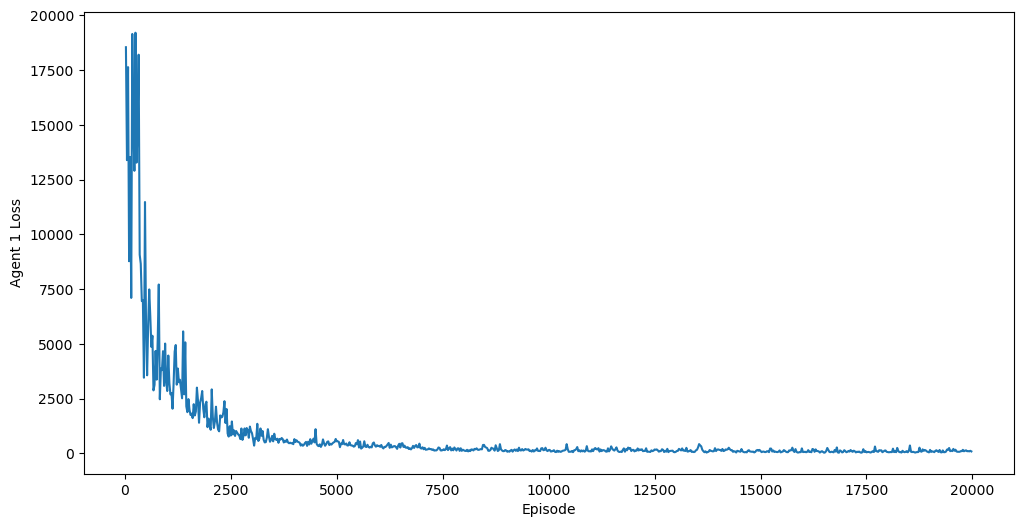

#### **Agent 2**

In [20]:
# metrics.display_metrics("loss_2", "Agent 2 Loss", "Episode")

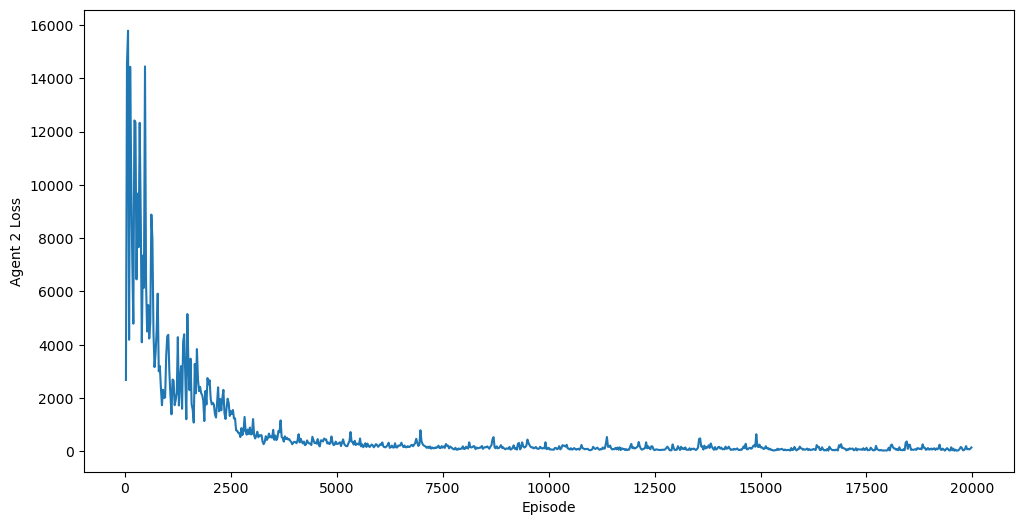

### Average Cumulated Rewards
The average rewards cumulated across 1000 configurations, measured at intervals of 500 episodes.

The average cumulated rewards increased at later episodes, indicating that the agents learned and took less penalty due to making unoptimal moves as training progresses.

In [21]:
# metrics.display_metrics("average_cumulated_rewards", "Average Cumulated Rewards")

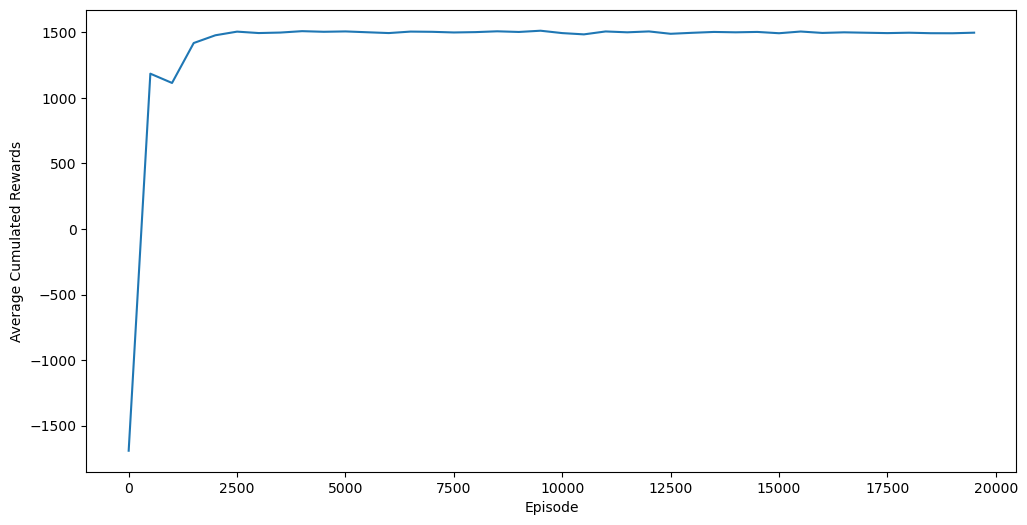

### Average Excess Steps
The average number of steps exceeding the optimal, across 1000 tests, measured at intervals of 500 episodes.

The excess number of steps taken decreased as training progressed, indicating that the agent learned and worked towards making optimal moves.

In [22]:
# metrics.display_metrics("average_excess_steps", "Average Excess Steps")

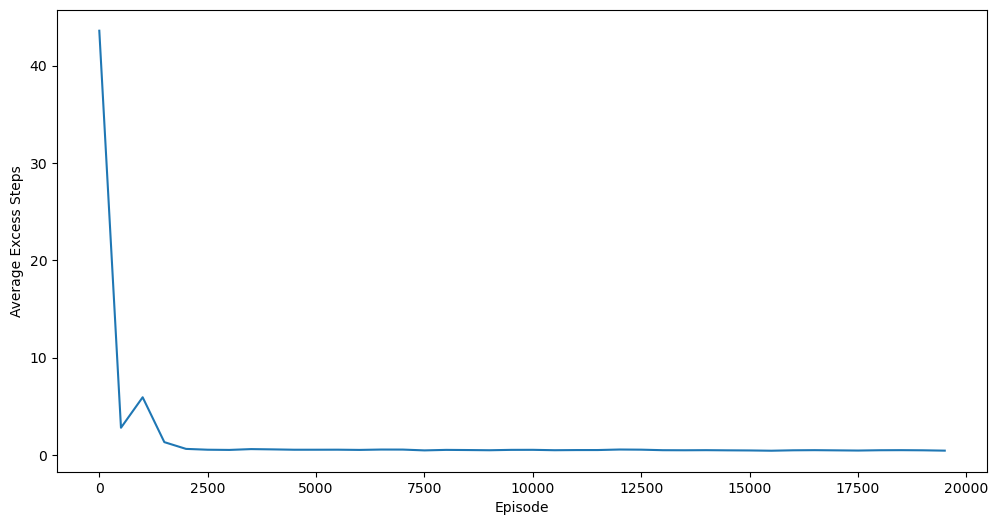

### Success Rate
The percentage of successful goal completions by the agent across 1000 tests, measured at intervals of 500 episodes.

The agent reached the goal more often as training progressed, ultimately reaching 100% success rate. This indicates that the agent has learned how to solve the task.

In [23]:
# metrics.display_metrics("success_rate", "Success Rate (%)")

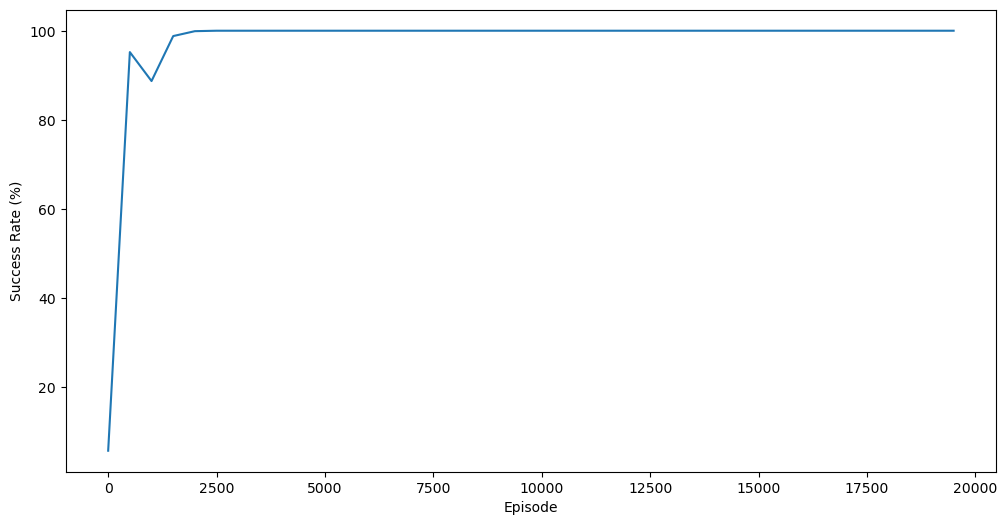

## Performance Evaluation Metrics

Testing the agents on ALL possible configurations. 

**Note:** While there are ways to optimise this process by testing on only 1 pair of agents at a time, I have chosen to test on all possible configurations for an exhaustive performance analysis.

In [ ]:
# The commented-out permutation below was used to test the agents on the full set of previously extracted configurations (stored in all_count_set). This gave a rough idea of how well the agents were 
# performing on this small subset of configurations. This was heavily used to tune the hyperparameters and ensure the agents are learning effectively during the experimentation phase of this assignment.
# It is left here for reference purposes, but it is not used in the final testing phase as it is not fully representative of the agents' performance on the full set of configurations.
# permutations = list(all_count_set)

# This set of permutations is all possible configurations that do not involve the agents starting at the extraction point. All functionally equivalent configurations are removed (for more information on this
# please kindly review the generate_initial_configurations() method of the OPC class))
permutations = list(opc.results.keys())

test_progress = tqdm(permutations, desc="Testing", total=len(permutations))

num_optimal = 0
num_suboptimal = 0

list_most_optimal = []
list_optimal = []
list_suboptimal = []

num_steps_list = []
total_excess_steps = 0

num_failed = 0

skipped = 0

for agent_1a_x, agent_1a_y, agent_1b_x, agent_1b_y, agent_2a_x, agent_2a_y, agent_2b_x, agent_2b_y, b_x, b_y in test_progress:
    if ((agent_1a_x, agent_1a_y) == (b_x, b_y) or 
        (agent_1b_x, agent_1b_y) == (b_x, b_y) or 
        (agent_2a_x, agent_2a_y) == (b_x, b_y) or 
        (agent_2b_x, agent_2b_y) == (b_x, b_y)):
        skipped += 1
        continue

    world.reset_with_params(agent_1a_x, agent_1a_y, agent_1b_x, agent_1b_y, agent_2a_x, agent_2a_y, agent_2b_x, agent_2b_y, b_x, b_y)
    
    i = 0



    while not world.state.isTerminal() and i < GRID_HEIGHT * GRID_WIDTH * 2:
        # if world.agent_to_move_first == 1:
        #     agents = [world.agent_1a, world.agent_2a, world.agent_1b, world.agent_2b]
        # else:
        #     agents = [world.agent_2a, world.agent_1a, world.agent_2b, world.agent_1b]

        agents = [world.agent_1a, world.agent_2a, world.agent_1b, world.agent_2b]
        shuffle(agents)

        for agent in agents:
            agent.opposite_pos = world.closest_opposite_agent(agent).agent_pos
            action = agent.bestAction()
            world.applyAction(agent, action)
            if world.state.isTerminal():
                break
        i += 1

    if i < world.min_steps:
        num_optimal += 1
        list_most_optimal.append((agent_1a_x, agent_1a_y, agent_1b_x, agent_1b_y, agent_2a_x, agent_2a_y, agent_2b_x, agent_2b_y, b_x, b_y))
    elif i == world.min_steps:
        num_optimal += 1
        list_optimal.append((agent_1a_x, agent_1a_y, agent_1b_x, agent_1b_y, agent_2a_x, agent_2a_y, agent_2b_x, agent_2b_y, b_x, b_y))
    elif i > world.min_steps:
        list_suboptimal.append((agent_1a_x, agent_1a_y, agent_1b_x, agent_1b_y, agent_2a_x, agent_2a_y, agent_2b_x, agent_2b_y, b_x, b_y))
        if i >= GRID_HEIGHT * GRID_WIDTH * 2:
            num_failed += 1
        else:
            num_suboptimal += 1
            total_excess_steps += i - world.min_steps
            num_steps_list.append(i)

Testing: 100%|██████████| 2250000/2250000 [19:24<00:00, 1932.66it/s]


In [ ]:
# NOTE: SAVE OR LOAD THE TEST DATA PICKLE FILES HERE!!!
# Save the test data
test_data = {
    "num_optimal": num_optimal,
    "num_suboptimal": num_suboptimal,
    "num_failed": num_failed,
    "total_excess_steps": total_excess_steps,
    "num_steps_list": num_steps_list,
    "skipped": skipped
}

with open(f"{seed}_test_data.pkl", "wb") as f:
    pickle.dump(test_data, f)

# # Load the test data
# with open(f"{seed}_test_data.pkl", "rb") as f:
#     test_data = pickle.load(f)

# permutations = list(opc.results.keys())
# num_optimal = test_data["num_optimal"]
# num_suboptimal = test_data["num_suboptimal"]
# num_failed = test_data["num_failed"]
# total_excess_steps = test_data["total_excess_steps"]
# num_steps_list = test_data["num_steps_list"]
# skipped = test_data["skipped"]

In [26]:
print(f"Total tested configurations: {len(permutations) - skipped}")
print(f"Optimal: {num_optimal}")
print(f"Suboptimal: {num_suboptimal}")
print(f"Failed to solve: {num_failed}")
print(f"Illegal config skipped: {skipped}")
print(f"Average excess steps: {total_excess_steps / (len(permutations) - skipped)}")
print(f"Percentage of cases solved under 15 steps: {(len(permutations) - skipped - len([x for x in num_steps_list if x > 15]) - num_failed) / (len(permutations) - skipped) * 100}%")

Total tested configurations: 2250000
Optimal: 1864650
Suboptimal: 385350
Failed to solve: 0
Illegal config skipped: 0
Average excess steps: 0.25560666666666665
Percentage of cases solved under 15 steps: 100.0%


# Performance Metrics Results

| Seed      | Scenarios Solved in Less Than 15 Steps | Epochs (Episodes) Required to Train to This Level | Average Excess Path Length (Step Count) |
|-----------|-----------------------------------------|---------------------------------------------------|------------------------------------------|
| 34553312  | 100%                                    | 19999                                             | 0.372764                                 |
| 32459525  | 100%                                    | 19999                                             | 0.4652742222222222                       |
| 17287966  | 100%                                    | 19999                                             | 0.43878666666666666                      |
| 3210744   | 100%                                    | 19999                                             | 0.4507648888888889                       |
| 28189744  | 100%                                    | 19999                                             | 0.4096711111111111                       |
| 20067541  | 100%                                    | 19999                                             | 0.42696755555555554                      |
| 32773548  | 100%                                    | 19999                                             | 0.3781168888888889                       |
| 19616403  | 100%                                    | 19999                                             | 0.4082408888888889                       |
| 33254042  | 100%                                    | 19999                                             | 0.4421591111111111                       |
| 33725772  | 100%                                    | 19999                                             | 0.38652                                  |

**Note:** These results were obtained with the seeds seen on the leftmost column. The seeds can be applied at the beginning of this notebook to fully and completely reproduce these results.

**Note 2:** The seeds were generated randomly using random.org to separate the seeding from the codebase.

**Note 3:** The Average Excess Path Length (Step Count) was calculated with the optimal path length calculated **with NO WAIT ACTION** taken into consideration.

# Interactive Visualisation

There are two types of interactive visualisations that I included in this project. Each type of visualisation can be accessed by pressing the respective button.

### Viewing Training Episode (**View Training Episode button**)
1. Enter the episode you want to view
2. Click Submit

or alternatively

1. Click *Randomise Episode* to view a random episode

### Testing the agents with a specified starting configuration (**Test with Specified Position button**)
1. Enter the starting configuration for agents of type 1. The input can either be (x, y, x, y), ((x, y), (x, y)), or (x, y), (x, y)
2. Enter the starting configuration for agents of type 2. The input can either be (x, y, x, y), ((x, y), (x, y)), or (x, y), (x, y)
3. Enter the position for B. The input can either be (x, y) or x, y
3. Click Submit

or alternatively

1. Click *Random Position* to test with random starting positions.

**NOTE**: The numbering of the grid starts from 0, with the top left corner being (0, 0) and the bottom right corner being (GRID_HEIGHT - 1, GRID_WIDTH - 1).

You can now use the navigation buttons to go forward and backward in the episode. Please note that:
1. Next Substep/Previous Substep will go 1 substep forward/backward. This will move the episode along agent by agent.
2. Next Step/Previous Step will go 1 step forward/backward. This will move the episode along step by step.
+ The Next Step button will always iterate to the last recorded substep of a given step. For example, if you are currently at Step 2 (2/4), you will be moved to Step 2(4/4) then subsequently to Step 3(4/4). 
+ The Previous Step button will always iterate to the last recorded substep of a given step. For example, if you are currently at Step 3 (2/4), you will be moved to Step 2(4/4) then subsequently to Step 1(4/4).

In [27]:
import numpy as np
import matplotlib
matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
from matplotlib.widgets import Button, TextBox
import matplotlib.cm as cm

from enum import Enum

In [28]:
# Function used to wipe the plot clean and reconstruct the grid
def reset_plot():
    global fig, ax

    ax.clear()

    plt.subplots_adjust(bottom = 0.35)

    # Move the x axis to the top of the plot and invert the y axis
    ax.xaxis.tick_top()

    if not ax.yaxis_inverted():
        ax.invert_yaxis()
    

    # Set the ticks of the x and y axis to align with the grid
    ax.set_xticks(np.arange(0, GRID_WIDTH + 1, 1))
    ax.set_yticks(np.arange(0, GRID_HEIGHT + 1, 1))

    # Make the ticks and the numbers on the axis invisible
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Display the grid
    ax.grid(True)

    # Make the plot square
    ax.set_aspect('equal')

    plt.draw()

In [ ]:
# Function used to display the state on the grid
def display_state_on_grid(state: tuple):
    global fig, ax, agent_mapping, agents

    agent_mapping = {
        "1a": agents.index(world.agent_1a),
        "2a": agents.index(world.agent_2a),
        "1b": agents.index(world.agent_1b),
        "2b": agents.index(world.agent_2b)
    }

    # Clear the plot
    reset_plot()

    # print(state)
    tmp_agent_1a = Agent1()
    tmp_agent_1b = Agent1()
    tmp_agent_2a = Agent2()
    tmp_agent_2b = Agent2()
    
    tmp_agent_1a.reset_with_params(*state[0][0])
    tmp_agent_1b.reset_with_params(*state[0][1])
    tmp_agent_2a.reset_with_params(*state[0][2])
    tmp_agent_2b.reset_with_params(*state[0][3])

    b_pos = state[0][-1]

    # Colours (in order 1a, 1b, 2a, 2b)
    colours = ['red', 'red', 'green', 'green']

    if tmp_agent_1a.has_secret:
        colours[0] = 'deeppink'
    if tmp_agent_1b.has_secret:
        colours[1] = 'deeppink'
    if tmp_agent_2a.has_secret:
        colours[2] = 'mediumseagreen'
    if tmp_agent_2b.has_secret:
        colours[3] = 'mediumseagreen'

    # Display agent 1s
    # ax.add_patch(plt.Rectangle((state.a_x, state.a_y), 1, 1, color='red'))
    ax.add_patch(plt.Rectangle((tmp_agent_1a.agent_pos[0], tmp_agent_1a.agent_pos[1]), 1, 1, color=colours[0]))
    ax.add_patch(plt.Rectangle((tmp_agent_1b.agent_pos[0], tmp_agent_1b.agent_pos[1]), 1, 1, color=colours[1]))

    # Display agent 2s
    # ax.add_patch(plt.Rectangle((state.b_x, state.b_y), 1, 1, color='green'))
    ax.add_patch(plt.Rectangle((tmp_agent_2a.agent_pos[0], tmp_agent_2a.agent_pos[1]), 1, 1, color=colours[2]))
    ax.add_patch(plt.Rectangle((tmp_agent_2b.agent_pos[0], tmp_agent_2b.agent_pos[1]), 1, 1, color=colours[3]))

    # Display the delivery point
    # ax.add_patch(plt.Rectangle((state.agent_x, state.agent_y), 1, 1, color='blue'))
    ax.add_patch(plt.Rectangle((b_pos[0], b_pos[1]), 1, 1, color='blue'))

    # Check if agent 1s and agent 2s are at the same position
    for agent in [tmp_agent_1a, tmp_agent_1b]:
        if agent.agent_pos in [tmp_agent_2a.agent_pos, tmp_agent_2b.agent_pos]:
            ax.add_patch(plt.Rectangle((agent.agent_pos[0], agent.agent_pos[1]), 1, 1, color='darksalmon'))
    
    for agent in [tmp_agent_2a, tmp_agent_2b]:
        if agent.agent_pos in [tmp_agent_1a.agent_pos, tmp_agent_1b.agent_pos]:
            ax.add_patch(plt.Rectangle((agent.agent_pos[0], agent.agent_pos[1]), 1, 1, color='darksalmon'))
    
    # If any agent is at the same position as B
    if b_pos in [tmp_agent_1a.agent_pos, tmp_agent_1b.agent_pos, tmp_agent_2a.agent_pos, tmp_agent_2b.agent_pos]:
        ax.add_patch(plt.Rectangle((b_pos[0], b_pos[1]), 1, 1, color='darkturquoise'))

    if (b_pos == tmp_agent_1a.agent_pos and tmp_agent_1a.has_secret) or (b_pos == tmp_agent_1b.agent_pos and tmp_agent_1b.has_secret) or (b_pos == tmp_agent_2a.agent_pos and tmp_agent_2a.has_secret) or (b_pos == tmp_agent_2b.agent_pos and tmp_agent_2b.has_secret):
        ax.add_patch(plt.Rectangle((b_pos[0], b_pos[1]), 1, 1, color='dodgerblue'))

    # Get grid size
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    # Display legend
    ax.text(-3 * x_max / 5, 2.1 * y_min / 5, "Legend:", fontsize=10)
    ax.text(-3 * x_max / 5, 2.5 * y_min / 5, "Agent 1s", fontsize=10, color='red')
    ax.text(-3 * x_max / 5, 2.9 * y_min / 5, "Agent 1s /w secret", fontsize=10, color='deeppink')
    ax.text(-3 * x_max / 5, 3.3 * y_min / 5, "Agent 2s", fontsize=10, color='green')
    ax.text(-3 * x_max / 5, 3.7 * y_min / 5, "Agent 2s /w secret", fontsize=10, color='mediumseagreen')
    ax.text(-3 * x_max / 5, 4.1 * y_min / 5, "Agent 1&2 overlap", fontsize=10, color='darksalmon')
    ax.text(-3 * x_max / 5, 4.5 * y_min / 5, "B (Delivery point)", fontsize=10, color='blue')
    ax.text(-3 * x_max / 5, 4.9 * y_min / 5, "Agent at B", fontsize=10, color='darkturquoise')
    ax.text(-3 * x_max / 5, 5.3 * y_min / 5, "Agent at B /w secret", fontsize=10, color='dodgerblue')

    # Display agent 1s current position in text
    agent_pos_text_y_pos = [2, 2.5, 3, 3.5]

    ax.text(5.5 * x_max / 5, 1.5 * y_min / 5, f"Agents' status\n(In order):", fontsize=10)
    ax.text(5.5 * x_max / 5, agent_pos_text_y_pos[agent_mapping["1a"]] * y_min / 5, f"Agent 1a: {tmp_agent_1a.agent_pos}", fontsize=10, color=colours[0])
    ax.text(5.5 * x_max / 5, agent_pos_text_y_pos[agent_mapping["1b"]] * y_min / 5, f"Agent 1b: {tmp_agent_1b.agent_pos}", fontsize=10, color=colours[1])
    ax.text(5.5 * x_max / 5, agent_pos_text_y_pos[agent_mapping["2a"]] * y_min / 5, f"Agent 2a: {tmp_agent_2a.agent_pos}", fontsize=10, color=colours[2])
    ax.text(5.5 * x_max / 5, agent_pos_text_y_pos[agent_mapping["2b"]] * y_min / 5, f"Agent 2b: {tmp_agent_2b.agent_pos}", fontsize=10, color=colours[3])

    # plt.draw()

In [30]:
# Function used to display the path the agent will take to reach the terminal state from its current position.
def show_full_path():
    global fig, ax, s, vis_states, state_index

    for i, state in enumerate(vis_states): 
        # Skip states that have already been visited
        if i <= state_index:
            continue

        ax.add_patch(plt.Rectangle((state.agent_x, state.agent_y), 1, 1, color=cm.viridis((state_index + i) / (len(vis_states) + state_index))))
        

    plt.draw()

In [ ]:
# Function used to move the agent to the next state
def next_substep(event):
    global state_index, vis_states, text_current_move_count, button_show_path
    state_index += 1

    reset_plot()

    if state_index >= len(vis_states):
        state_index -= 1

    # Update relevant labels
    if state_index == 0:
        text_current_move_count.set_text(f"Current step count: 0 (0/0)")
    else:
        text_current_move_count.set_text(f"Current step count: {(state_index - 1) // 4 + 1} ({(state_index - 1) % 4 + 1}/4)")
    # button_show_path.label.set_text("Show Path")

    display_state_on_grid(vis_states[state_index])

# Function used to move the agent to the previous state
def previous_substep(event):
    global state_index, vis_states, text_current_move_count, button_show_path
    state_index -= 1

    reset_plot()

    if state_index < 0:
        state_index = 0
    
    # Update relevant labels
    if state_index == 0:
        text_current_move_count.set_text(f"Current step count: 0 (0/0)")
    else:
        text_current_move_count.set_text(f"Current step count: {(state_index - 1) // 4 + 1} ({(state_index - 1) % 4 + 1}/4)")
    # button_show_path.label.set_text("Show Path")

    display_state_on_grid(vis_states[state_index])

def next_step(event):
    global state_index, vis_states, text_current_move_count, button_show_path
    state_index += 4

    if state_index >= len(vis_states):
        state_index = len(vis_states) - 1
    else:
        if state_index % 4 != 0:
            state_index -= state_index % 4

    reset_plot()

    if state_index >= len(vis_states):
        state_index -= 1

    # Update relevant labels
    if state_index == 0:
        text_current_move_count.set_text(f"Current step count: 0 (0/0)")
    else:
        text_current_move_count.set_text(f"Current step count: {(state_index - 1) // 4 + 1} ({(state_index - 1) % 4 + 1}/4)")
    # button_show_path.label.set_text("Show Path")

    display_state_on_grid(vis_states[state_index])

# Function used to move the agent to the previous state
def previous_step(event):
    global state_index, vis_states, text_current_move_count, button_show_path
    state_index -= 4

    if state_index < 0:
        state_index = 0
    else:
        if state_index % 4 != 0:
            state_index += (4 - state_index % 4)

    reset_plot()

    if state_index < 0:
        state_index = 0
    
    # Update relevant labels
    if state_index == 0:
        text_current_move_count.set_text(f"Current step count: 0 (0/0)")
    else:
        text_current_move_count.set_text(f"Current step count: {(state_index - 1) // 4 + 1} ({(state_index - 1) % 4 + 1}/4)")
    # button_show_path.label.set_text("Show Path")

    display_state_on_grid(vis_states[state_index])

# Function used to toggle the display of the full path
def full_path_toggle(event):
    global vis_states, state_index, button_show_path

    # Rename triggering button
    if button_show_path.label.get_text() == "Show Path":
        button_show_path.label.set_text("Hide Path")
        show_full_path()
    else:
        button_show_path.label.set_text("Show Path")
        reset_plot()
        display_state_on_grid(vis_states[state_index])

    plt.draw()

# Function used to process the text input for the agent's position and A's position
def process_text(text):
    s = text
    s = s.replace(" ", "")
    s = s.replace("(", "")
    s = s.replace(")", "")

    values = s.split(",")

    if len(values) == 2:
        return int(values[0]), int(values[1])
    elif len(values) == 4:
        return int(values[0]), int(values[1]), int(values[2]), int(values[3])
    
# Function used to set the elements position on the grid with specified positions
def get_state(event):
    global text_agent_2s_pos, text_agent_1s_pos, text_b_pos, state_index, text_optimal, text_current_move_count, text_total_move, vis_states, agent_mapping, agents
    agent_1a_x, agent_1a_y, agent_1b_x, agent_1b_y = process_text(text_agent_1s_pos.text)
    agent_2a_x, agent_2a_y, agent_2b_x, agent_2b_y = process_text(text_agent_2s_pos.text)
    b_x, b_y = process_text(text_b_pos.text)
    
    # Use the agent to go find the optimal path
    world.reset_with_params(agent_1a_x, agent_1a_y, agent_1b_x, agent_1b_y, agent_2a_x, agent_2a_y, agent_2b_x, agent_2b_y, b_x, b_y)
    
    state_index = 0
    optimal_move_count = opc.results[world.initial_config][0][3]
    
    text_optimal.set_text(f"Optimal step: {optimal_move_count}")
    text_current_move_count.set_text(f"Current step count: 0 (0/0)")

    vis_states = [(world.state.configuration(), None, None, None, None)]

    current_step = 0

    while not world.state.isTerminal() and current_step < GRID_HEIGHT * GRID_WIDTH * 2:
        agents = [world.agent_1a, world.agent_2a, world.agent_1b, world.agent_2b]
        shuffle(agents)

        for i, agent in enumerate(agents):
            agent.opposite_pos = world.closest_opposite_agent(agent).agent_pos
            action = agent.bestAction()
            world.applyAction(agent, action)

            vis_states.append((world.state.configuration(), agent.configuration(), action.value, current_step, i))

            if world.state.isTerminal():
                break
        
        current_step += 1

    text_total_move.set_text(f"Total step count: {current_step}")

    display_state_on_grid(vis_states[state_index])

def get_state_random(event):
    global text_agent_2s_pos, text_agent_1s_pos, text_b_pos, state_index, text_optimal, text_current_move_count, text_total_move, vis_states, agent_mapping, agents
    
    agent_1a_x = np.random.randint(0, GRID_WIDTH)
    agent_1a_y = np.random.randint(0, GRID_HEIGHT)
    agent_1b_x = np.random.randint(0, GRID_WIDTH)
    agent_1b_y = np.random.randint(0, GRID_HEIGHT)
    agent_2a_x = np.random.randint(0, GRID_WIDTH)
    agent_2a_y = np.random.randint(0, GRID_HEIGHT)
    agent_2b_x = np.random.randint(0, GRID_WIDTH)
    agent_2b_y = np.random.randint(0, GRID_HEIGHT)

    while True:
        b_x = np.random.randint(0, GRID_WIDTH)
        b_y = np.random.randint(0, GRID_HEIGHT)

        if (agent_1a_x, agent_1a_y, agent_1b_x, agent_1b_y, agent_2a_x, agent_2a_y, agent_2b_x, agent_2b_y, b_x, b_y) not in list_suboptimal:
            if (b_x, b_y) not in [(agent_1a_x, agent_1a_y), (agent_1b_x, agent_1b_y), (agent_2a_x, agent_2a_y), (agent_2b_x, agent_2b_y)]:
                break

    
    text_agent_1s_pos.set_val(f"({agent_1a_x}, {agent_1a_y}, {agent_1b_x}, {agent_1b_y})")
    text_agent_2s_pos.set_val(f"({agent_2a_x}, {agent_2a_y}, {agent_2b_x}, {agent_2b_y})")
    text_b_pos.set_val(f"({b_x}, {b_y})")

    # Use the agent to go find the optimal path
    world.reset_with_params(agent_1a_x, agent_1a_y, agent_1b_x, agent_1b_y, agent_2a_x, agent_2a_y, agent_2b_x, agent_2b_y, b_x, b_y)
        
    state_index = 0
    optimal_move_count = opc.results[world.initial_config][0][3]
    
    text_optimal.set_text(f"Optimal step: {optimal_move_count}")
    text_current_move_count.set_text(f"Current step count: 0 (0/0)")

    vis_states = [(world.state.configuration(), None, None, None, None)]

    current_step = 0
    while not world.state.isTerminal() and current_step < GRID_HEIGHT * GRID_WIDTH * 2:
        agents = [world.agent_1a, world.agent_2a, world.agent_1b, world.agent_2b]
        shuffle(agents)

        for i, agent in enumerate(agents):
            agent.opposite_pos = world.closest_opposite_agent(agent).agent_pos
            action = agent.bestAction()
            world.applyAction(agent, action)

            vis_states.append((world.state.configuration(), agent.configuration(), action.value, current_step, i))

            if world.state.isTerminal():
                break
        
        current_step += 1

    text_total_move.set_text(f"Total step count: {current_step}")

    display_state_on_grid(vis_states[state_index])

# Function used to set the episode to display the agent's training path
def set_episode(event):
    global state_index, text_optimal, text_current_move_count, text_total_move, vis_states, episode_history, text_episode_input, agent_mapping
    episode = int(text_episode_input.text)

    s = episode_history[episode]
    state_index = 0
    optimal_move_count = opc.results[s["initial_config"]][0][3]
    total_steps = s["history"][-1][3] + 1

    world.reset_with_params(*s["initial_config"])

    text_optimal.set_text(f"Optimal step count: {optimal_move_count}")
    text_current_move_count.set_text(f"Current step count: 0 (0/0)")
    # text_current_sub_step.set_text(f"Current sub-step count: {s['history'][state_index][4]}")
    text_total_move.set_text(f"Total step count: {total_steps}")
    vis_states = [(world.state.configuration(), None, None, None, None)]
    vis_states += s["history"]
    display_state_on_grid(vis_states[state_index])



def set_random_episode(event):
    global state_index, text_optimal, text_current_move_count, text_total_move, vis_states, episode_history, text_episode_input, agent_mapping
    episode = np.random.randint(0, len(episode_history))
    text_episode_input.set_val(str(episode))

    s = episode_history[episode]
    state_index = 0
    optimal_move_count = opc.results[s["initial_config"]][0][3]
    total_steps = s["history"][-1][3] + 1

    world.reset_with_params(*s["initial_config"])

    text_optimal.set_text(f"Optimal step count: {optimal_move_count}")
    text_current_move_count.set_text(f"Current step count: 0 (0/0)")
    # text_current_sub_step.set_text(f"Current sub-step count: {s['history'][state_index][4]}")
    text_total_move.set_text(f"Total step count: {total_steps}")
    vis_states = [(world.state.configuration(), None, None, None, None)]
    vis_states += s["history"]
    display_state_on_grid(vis_states[state_index])

In [32]:
def view_training_episode(event):
    # All variables will be global
    global fig, ax, ax_next_substep, ax_previous_substep, ax_next_step, ax_previous_step, ax_show_path, ax_submit_pos, ax_view_training_episode, ax_test_with_random_pos, button_next_substep, button_previous_substep, button_next_step, button_previous_step, button_show_path, button_submit_pos, button_randomise_pos, button_view_training_episode, button_test_with_random_pos, ax_episode_input, text_episode_input, text_optimal, text_current_move_count, text_total_move, vis_states, state_index
    fig, ax = plt.subplots()

    # Reset
    reset_plot()
    vis_states = None
    state_index = None

    # Creating buttons
    # ax_next = plt.axes([0.81, 0.05, 0.1, 0.075])
    # ax_previous = plt.axes([0.7, 0.05, 0.1, 0.075])
    # ax_show_path = plt.axes([0.7, 0.15, 0.2, 0.075])
    ax_next_substep = plt.axes([0.81, 0.15, 0.1, 0.075])
    ax_previous_substep = plt.axes([0.7, 0.15, 0.1, 0.075])
    ax_next_step = plt.axes([0.81, 0.05, 0.1, 0.075])
    ax_previous_step = plt.axes([0.7, 0.05, 0.1, 0.075])
    ax_randomise_pos = plt.axes([0.41, 0.05, 0.2, 0.075])
    ax_submit_pos = plt.axes([0.2, 0.05, 0.2, 0.075])

    ax_view_training_episode = plt.axes([0.05, 0.7, 0.2, 0.075])
    ax_test_with_random_pos = plt.axes([0.05, 0.8, 0.2, 0.075])

    # button_show_path = Button(ax_show_path, 'Show Path')
    button_next_substep = Button(ax_next_substep, 'Next\nSubstep')
    button_previous_substep = Button(ax_previous_substep, 'Previous\nSubstep')
    button_next_step = Button(ax_next_step, 'Next\nFull Step')
    button_previous_step = Button(ax_previous_step, 'Previous\nFull Step')
    button_submit_pos = Button(ax_submit_pos, 'Submit')
    button_randomise_pos = Button(ax_randomise_pos, 'Randomise\nEpisode')
    button_view_training_episode = Button(ax_view_training_episode, 'View Training\nEpisode')
    button_test_with_random_pos = Button(ax_test_with_random_pos, 'Test with\nSpecified Position')

    # Create episode input text boxes
    ax_episode_input = plt.axes([0.4, 0.15, 0.1, 0.075])
    text_episode_input = TextBox(ax_episode_input, f'Input episode 0 to {len(episode_history) - 1} ', initial="0")

    # Create text labels
    text_optimal = plt.text(-3, 10.5, f"")
    text_current_move_count = plt.text(0, 10.5, f"")
    text_total_move = plt.text(3.5, 10.5, f"")

    # Connect buttons to functions
    button_next_substep.on_clicked(next_substep)
    button_previous_substep.on_clicked(previous_substep)
    # button_show_path.on_clicked(full_path_toggle)
    button_next_step.on_clicked(next_step)
    button_previous_step.on_clicked(previous_step)
    button_submit_pos.on_clicked(set_episode)
    button_randomise_pos.on_clicked(set_random_episode)


    button_view_training_episode.on_clicked(view_training_episode)
    button_test_with_random_pos.on_clicked(test_with_random_pos)

    plt.show()

In [33]:
def test_with_random_pos(event):
    global fig, ax, ax_next, ax_previous, ax_show_path, ax_submit_pos, ax_view_training_episode, ax_test_with_random_pos, button_next_substep, button_previous_substep, button_next_step, button_previous_step, button_show_path, button_submit_pos, button_randomise_pos, button_view_training_episode, button_test_with_random_pos, text_optimal, text_current_move_count, text_total_move, ax_agent_1s_pos, text_agent_1s_pos, ax_agent_2s_pos, text_agent_2s_pos, text_b_pos, vis_states, state_index

    fig, ax = plt.subplots()

    # Reset
    reset_plot()
    vis_states = None
    state_index = None

    # Creating buttons
    # ax_next = plt.axes([0.81, 0.05, 0.1, 0.075])
    # ax_previous = plt.axes([0.7, 0.05, 0.1, 0.075])
    # ax_show_path = plt.axes([0.7, 0.15, 0.2, 0.075])
    ax_next_substep = plt.axes([0.81, 0.15, 0.1, 0.075])
    ax_previous_substep = plt.axes([0.7, 0.15, 0.1, 0.075])
    ax_next_step = plt.axes([0.81, 0.05, 0.1, 0.075])
    ax_previous_step = plt.axes([0.7, 0.05, 0.1, 0.075])
    ax_submit_pos = plt.axes([0.41, 0.15, 0.2, 0.075])
    ax_randomise_pos = plt.axes([0.41, 0.05, 0.2, 0.075])

    ax_view_training_episode = plt.axes([0.05, 0.7, 0.2, 0.075])
    ax_test_with_random_pos = plt.axes([0.05, 0.8, 0.2, 0.075])

    # button_show_path = Button(ax_show_path, 'Show Path')
    button_next_substep = Button(ax_next_substep, 'Next\nSubstep')
    button_previous_substep = Button(ax_previous_substep, 'Previous\nSubstep')
    button_next_step = Button(ax_next_step, 'Next\nFull Step')
    button_previous_step = Button(ax_previous_step, 'Previous\nFull Step')
    button_submit_pos = Button(ax_submit_pos, 'Submit')
    button_randomise_pos = Button(ax_randomise_pos, 'Randomise\nPosition')
    
    button_view_training_episode = Button(ax_view_training_episode, 'View Training\nEpisode')
    button_test_with_random_pos = Button(ax_test_with_random_pos, 'Test with\nSpecified Position')

    # Create text labels
    text_optimal = plt.text(0.2, 1.8, f"")
    text_current_move_count = plt.text(1.7, 1.8, f"")
    text_total_move = plt.text(3.4, 1.8, f"")

    # Create text box to select a position
    ax_agent_1s_pos = plt.axes([0.25, 0.21, 0.135, 0.075])
    text_agent_1s_pos = TextBox(ax_agent_1s_pos, 'Agent 1s positions\n(x, y, x, y) ', initial="0")

    ax_agent_2s_pos = plt.axes([0.25, 0.13, 0.135, 0.075])
    text_agent_2s_pos = TextBox(ax_agent_2s_pos, 'Agent 2s positions\n(x, y, x, y) ', initial="0")

    ax_b_pos = plt.axes([0.25, 0.05, 0.135, 0.075])
    text_b_pos = TextBox(ax_b_pos, 'B position (x, y) ', initial="0")

    # Connect buttons to functions
    button_next_substep.on_clicked(next_substep)
    button_previous_substep.on_clicked(previous_substep)
    # button_show_path.on_clicked(full_path_toggle)
    button_next_step.on_clicked(next_step)
    button_previous_step.on_clicked(previous_step)
    button_submit_pos.on_clicked(get_state)
    button_randomise_pos.on_clicked(get_state_random)
    
    button_view_training_episode.on_clicked(view_training_episode)
    button_test_with_random_pos.on_clicked(test_with_random_pos)


    plt.show()

In [ ]:
# view_training_episode(None)
test_with_random_pos(None)

# Limitations and Findings: 

With the current implementation, the agents are able to learn in under 20000 episdes to solve all configurations with a 100% success rate and an average step count excess of <0.5. To achieve this level of performance, it was crucial that I was able to concretely coordinate the order in which the agents should move for a given configuration through the combination of the Central Clock option and the minimum step count calculation. Furthermore, with off-the-job training, I was able to select all configurations involving all optimal pairings of agents to train the agents on. Most importantly, it was most vital that my agents were able to perceive the closest agent of the opposite type to them, allowing some degree of coordination between the agents.

However, despite this level of performance, the agents are not able to achieve 100% optimality in all configurations. This is due to the fact each agent is not able to perceive the full environment (i.e. they can only observe themselves and the closest agent of the opposite type), making them prone to making suboptimal moves as the closest agent of the opposite type to them at a given moment may not be the agent that they should be coordinating with. This is especially true when the agents are in close proximity to each other. In short, while the agents are relatively performant in solving the task, they are unfortunately not perfect.

Furthermore, while the training process only takes around 5 minutes from the environment setup to the training evaluation metrics, the exhaustive performance evaluation metrics can take quite some time (>15 minutes) to complete. This is due to the exhaustive nature of the evaluation, where all possible configurations are tested. This can potentially be optimised by testing on only 1 pair of agents at a time, but I have chosen to test on all possible configurations for an exhaustive performance analysis as the interaction with another pair of agents can affect how the agents behave in the environment.

# Game Theory Analysis:

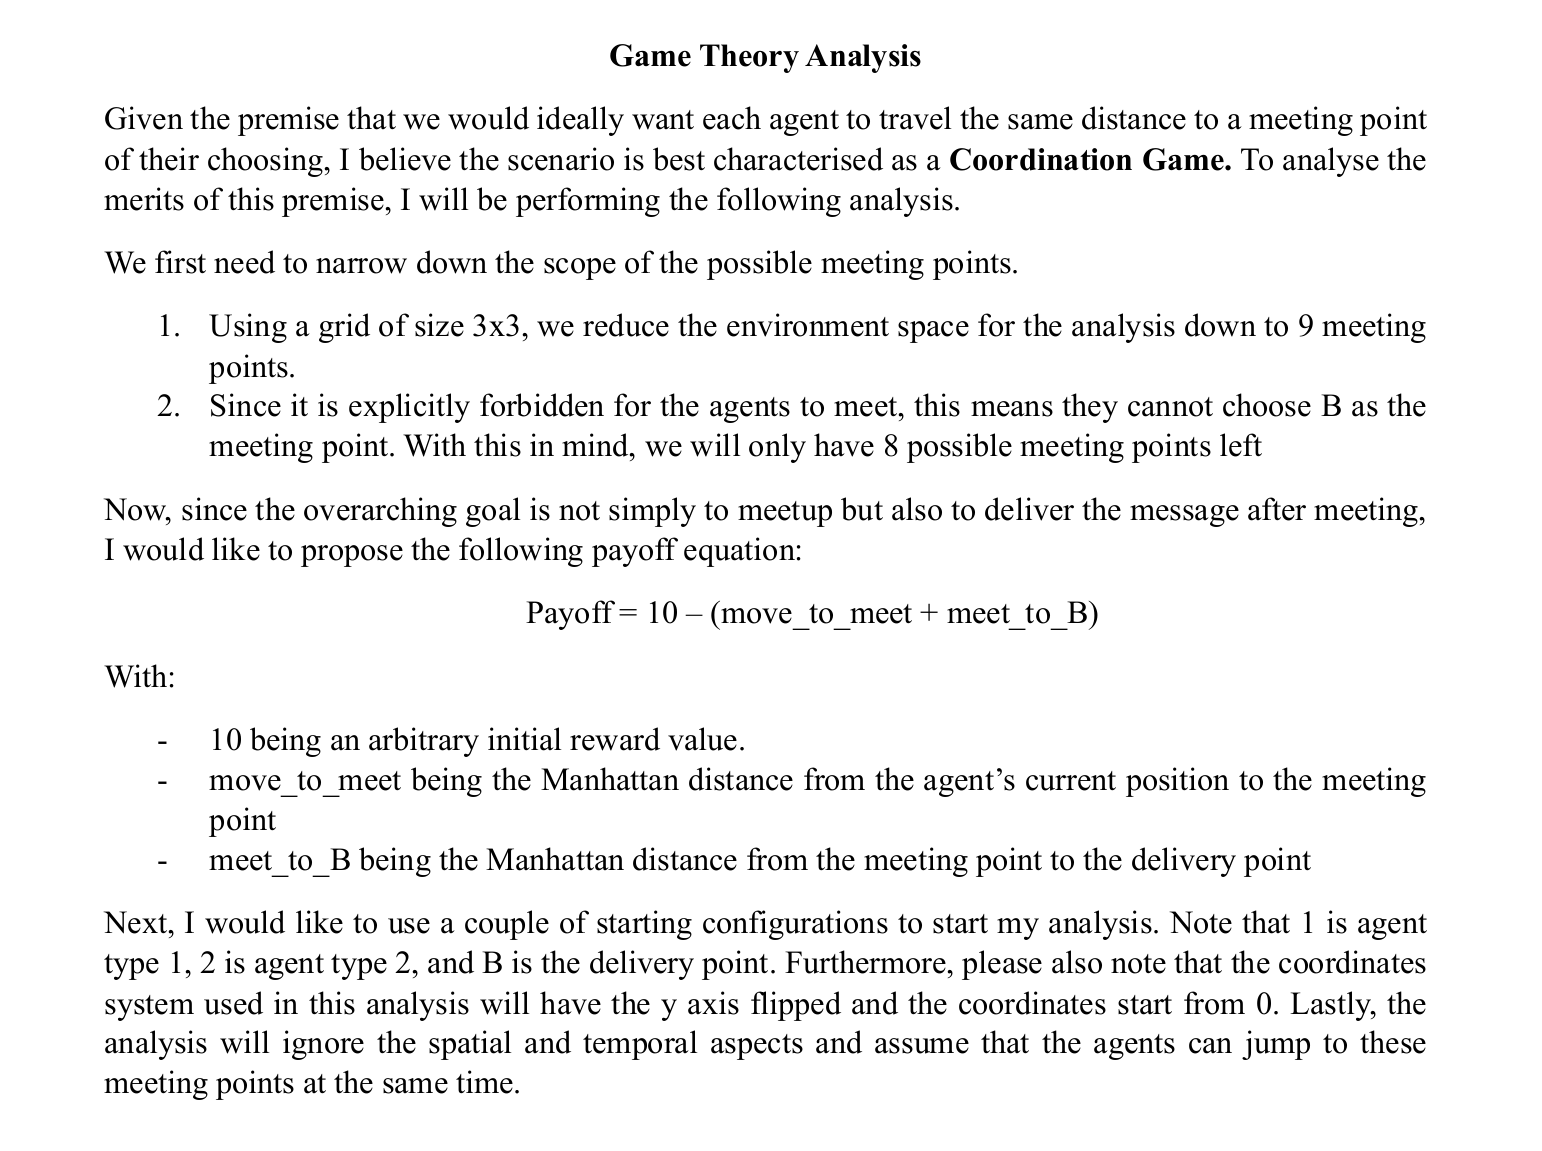

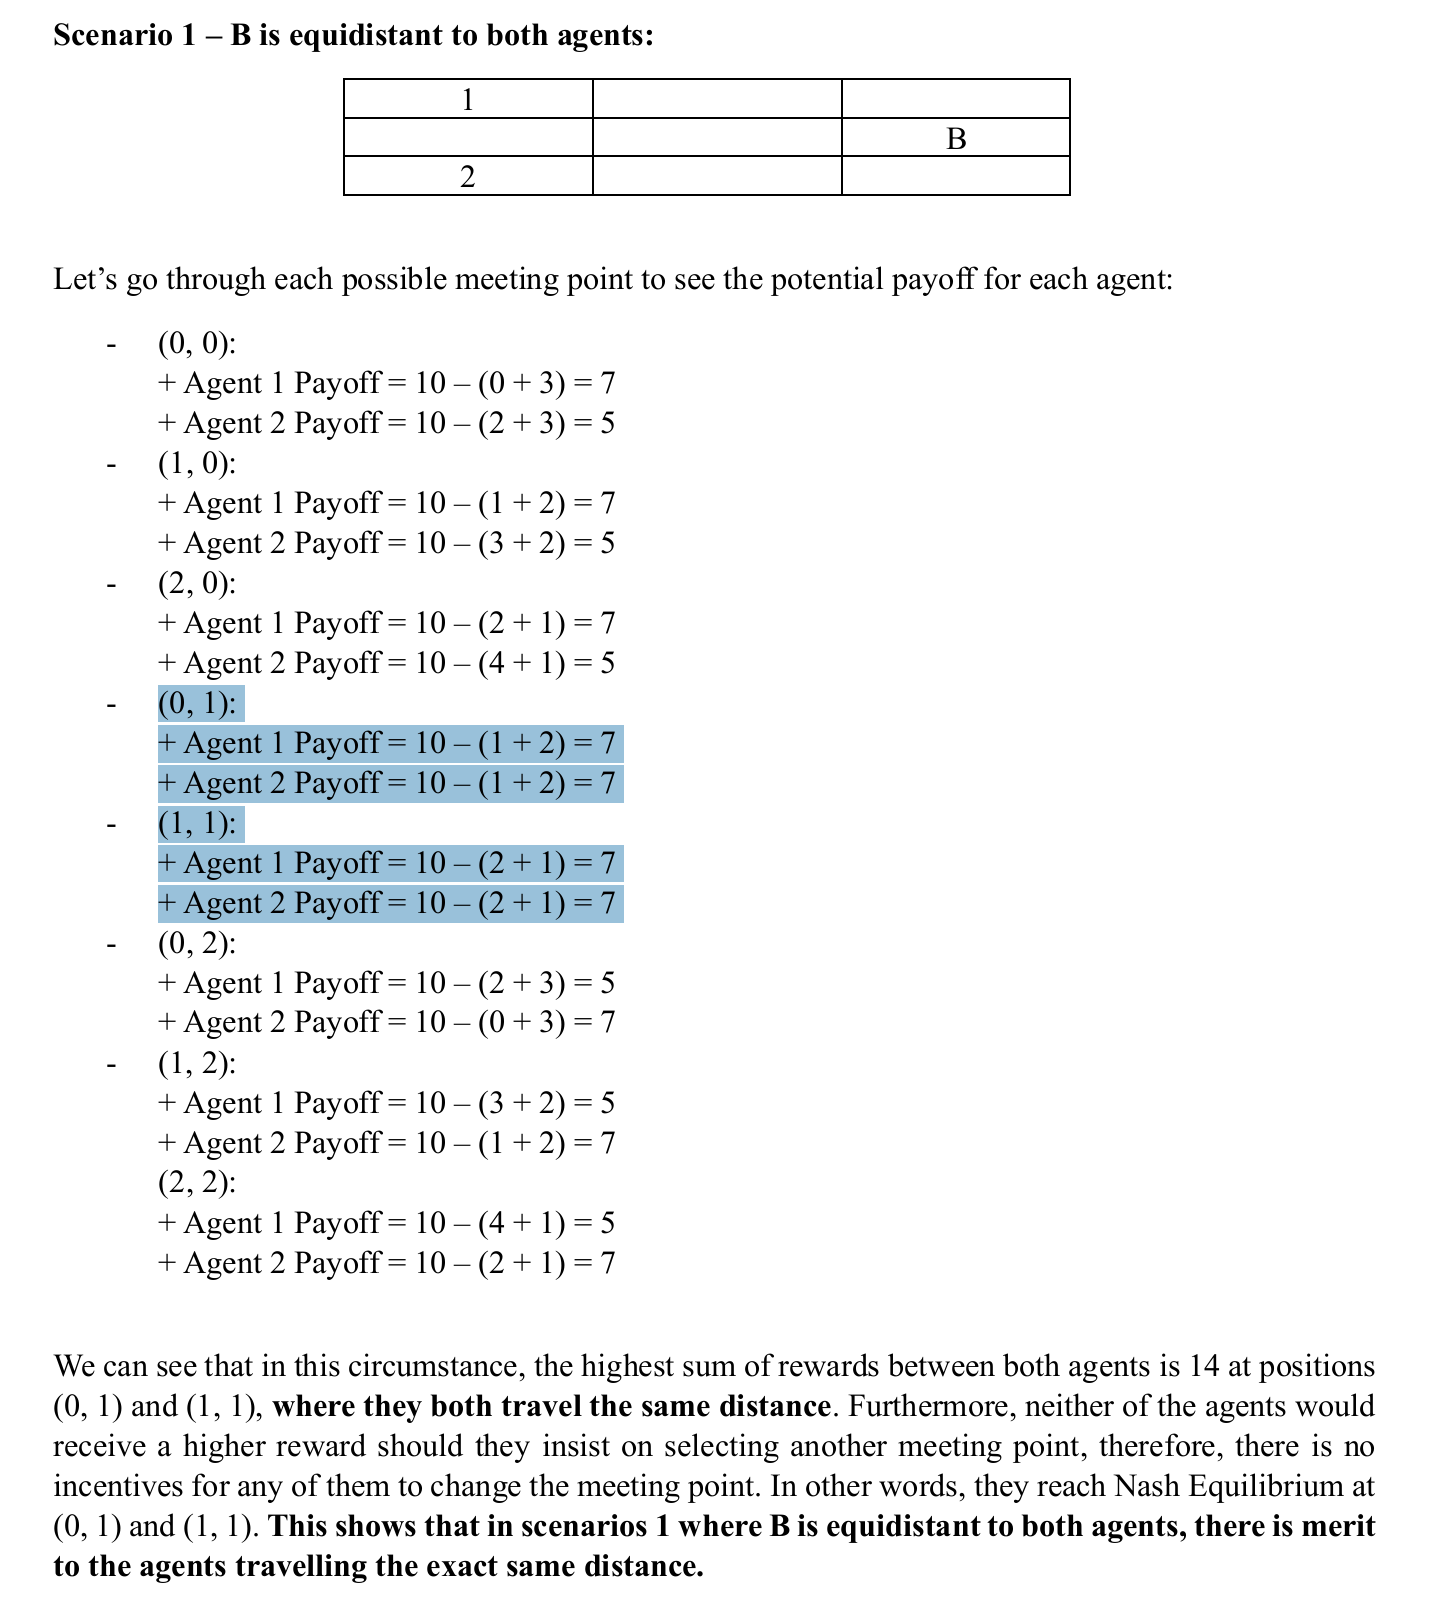

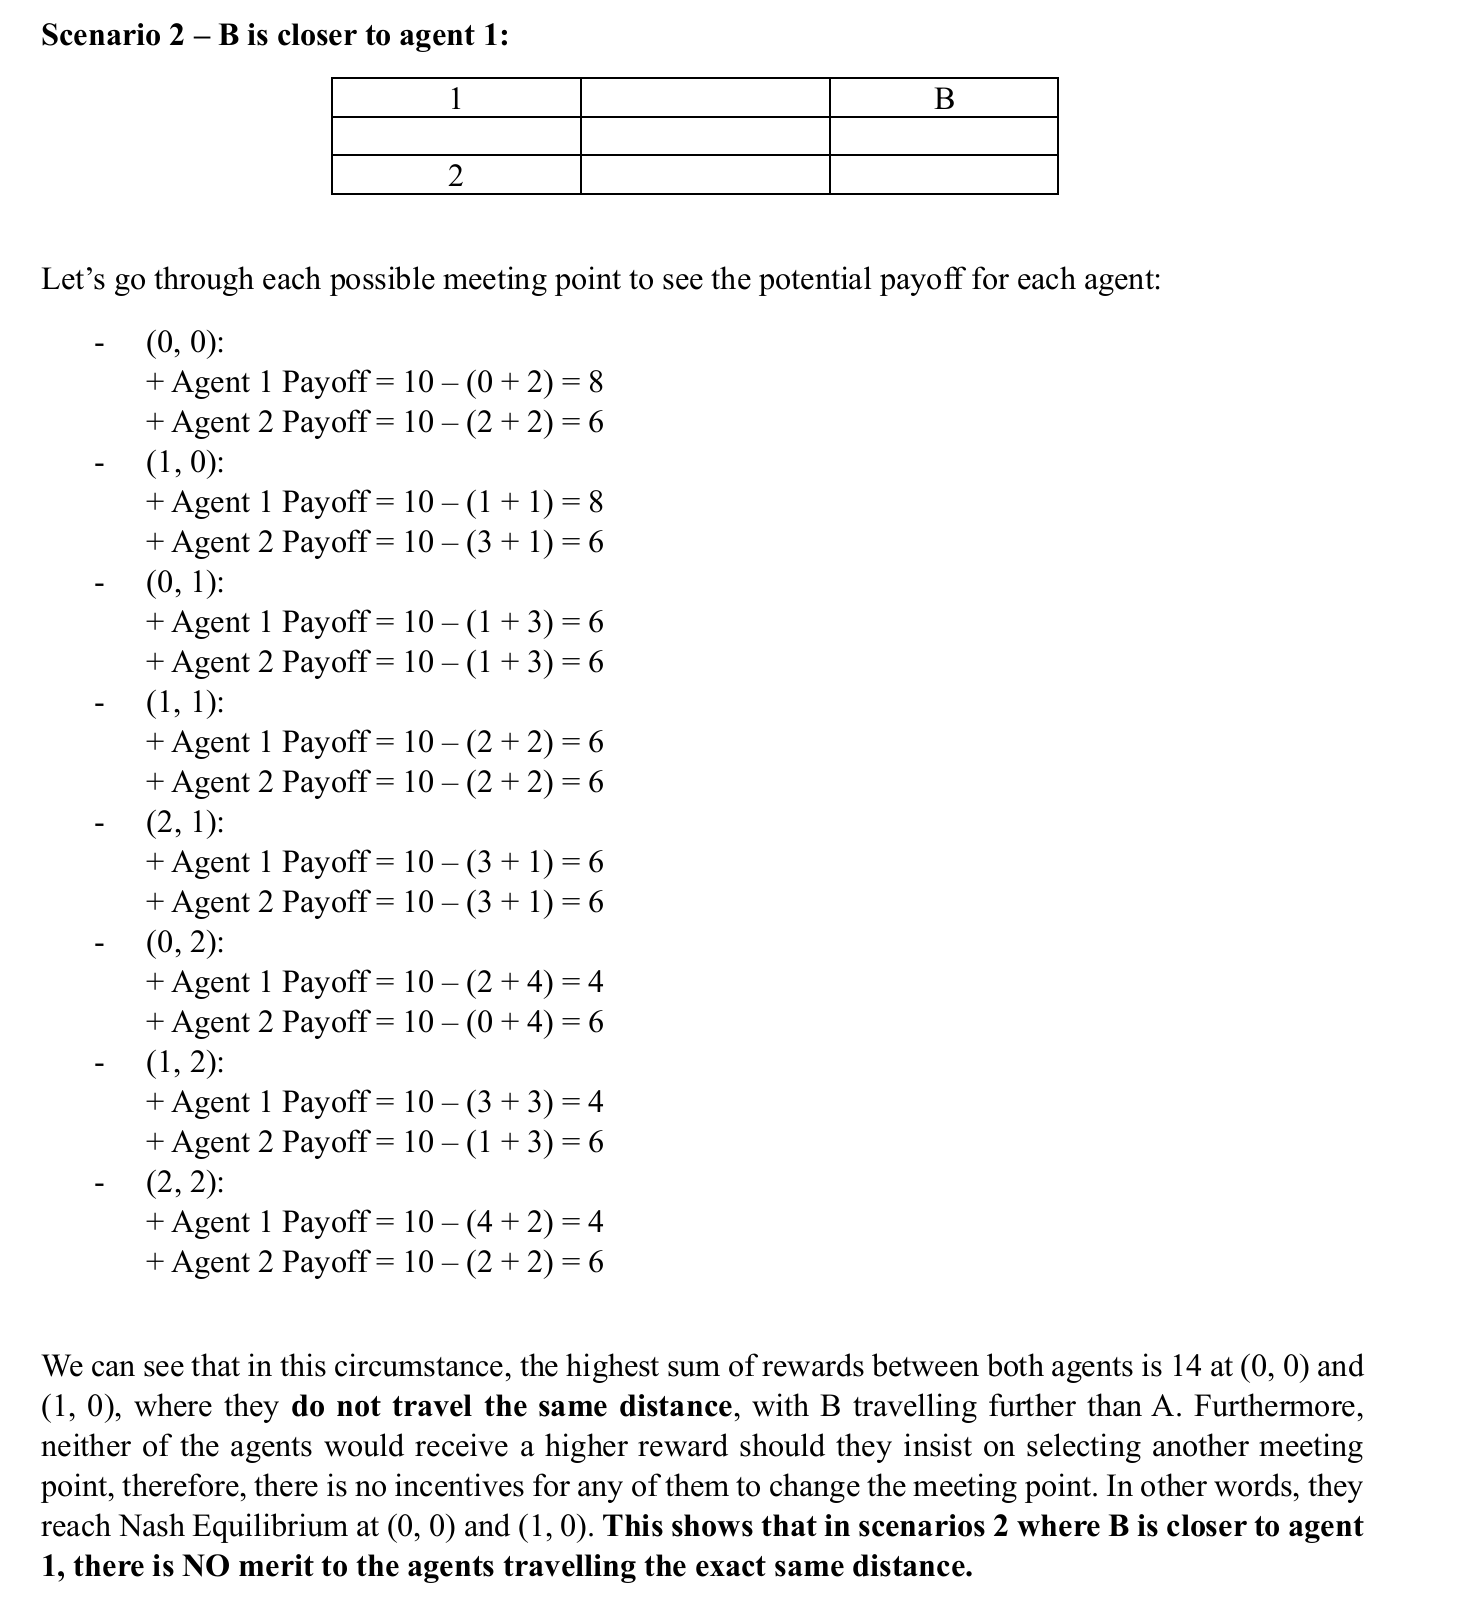

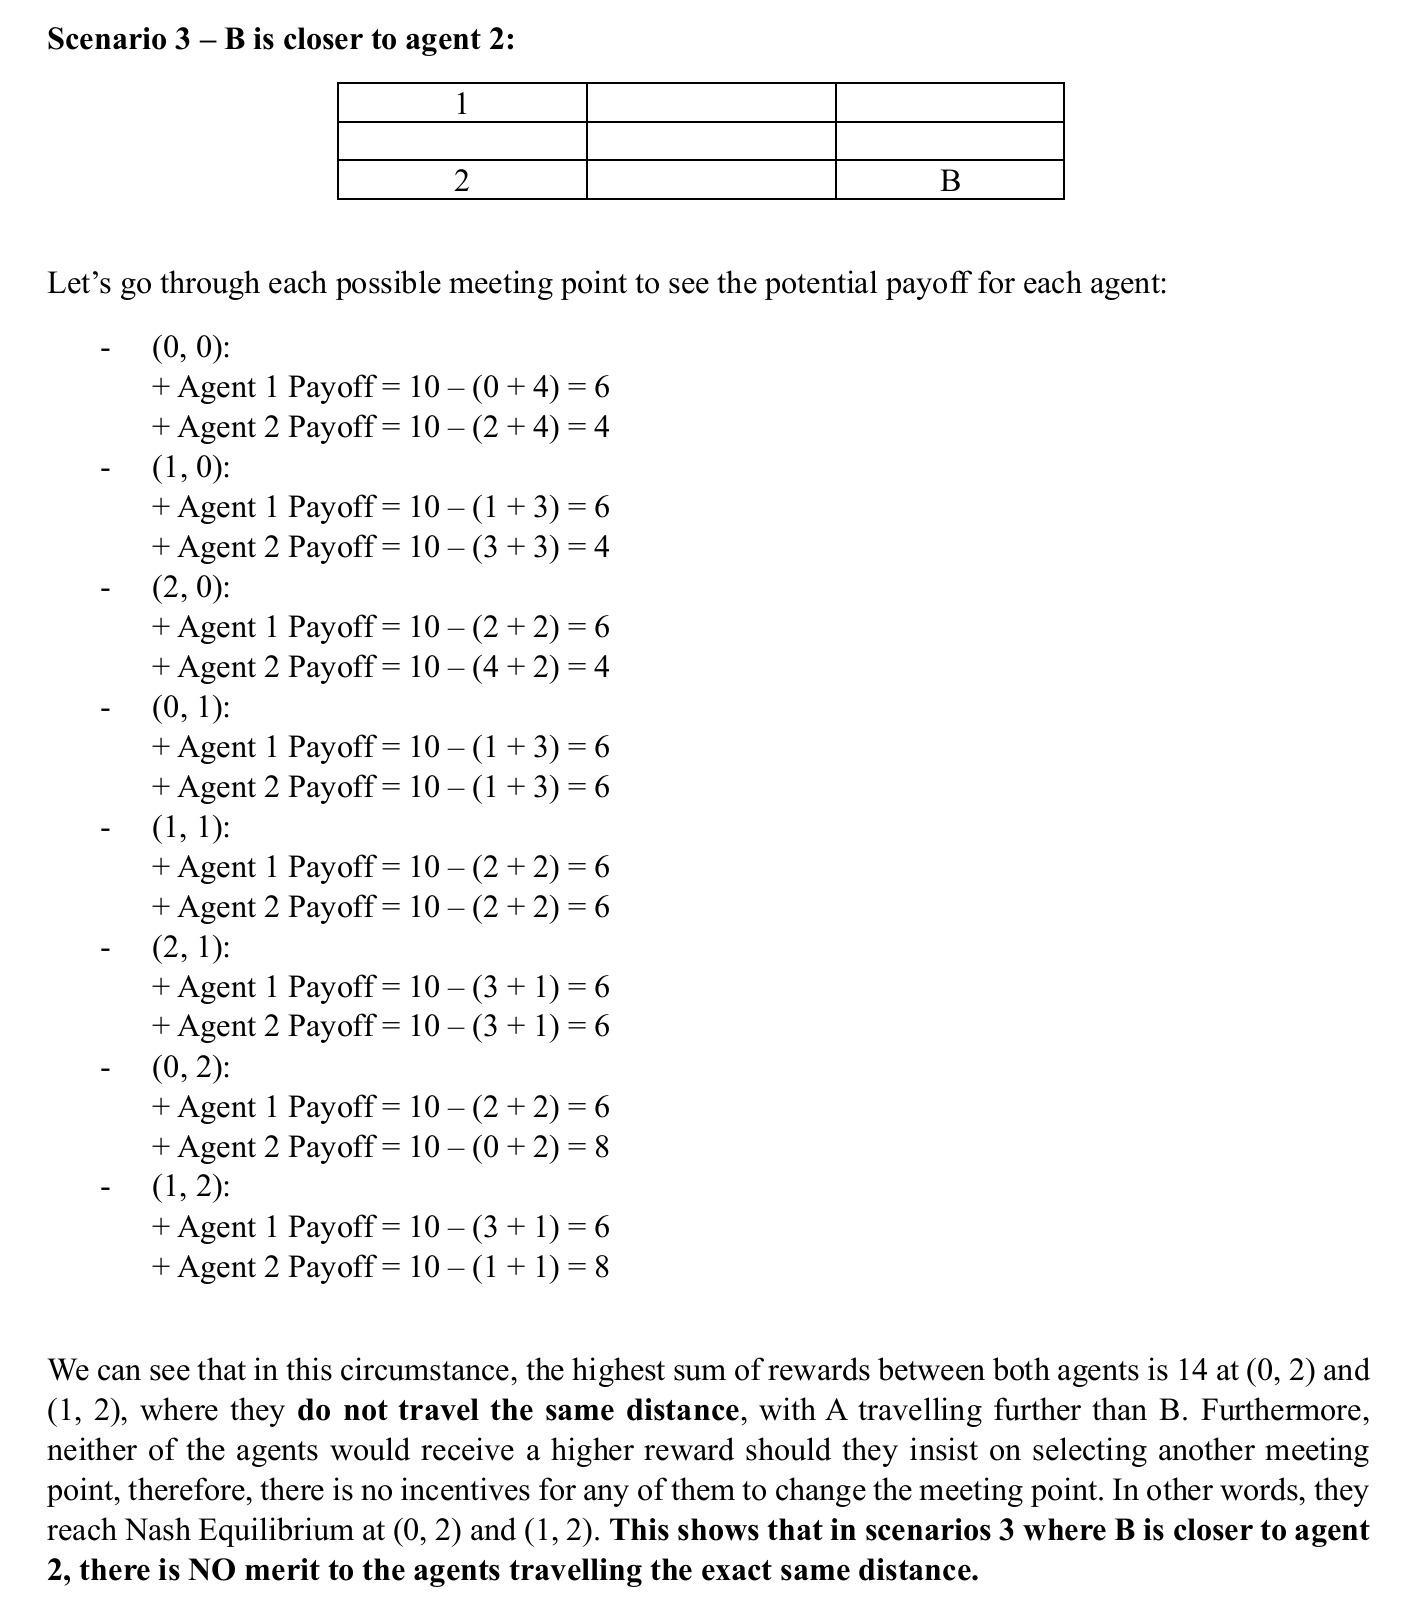

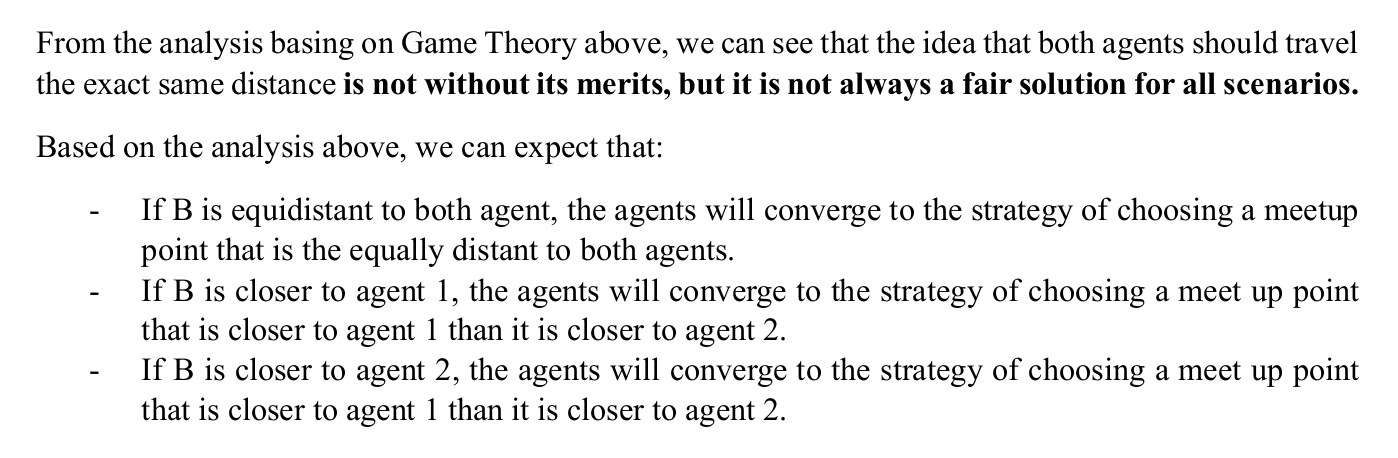